Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 11 - Asset allocation

## 11.1 Evaluating an equally-weighted portfolio's performance

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import quantstats as qs

2. Define the considered assets and download their prices from Yahoo Finance:

[*********************100%%**********************]  5 of 5 completed


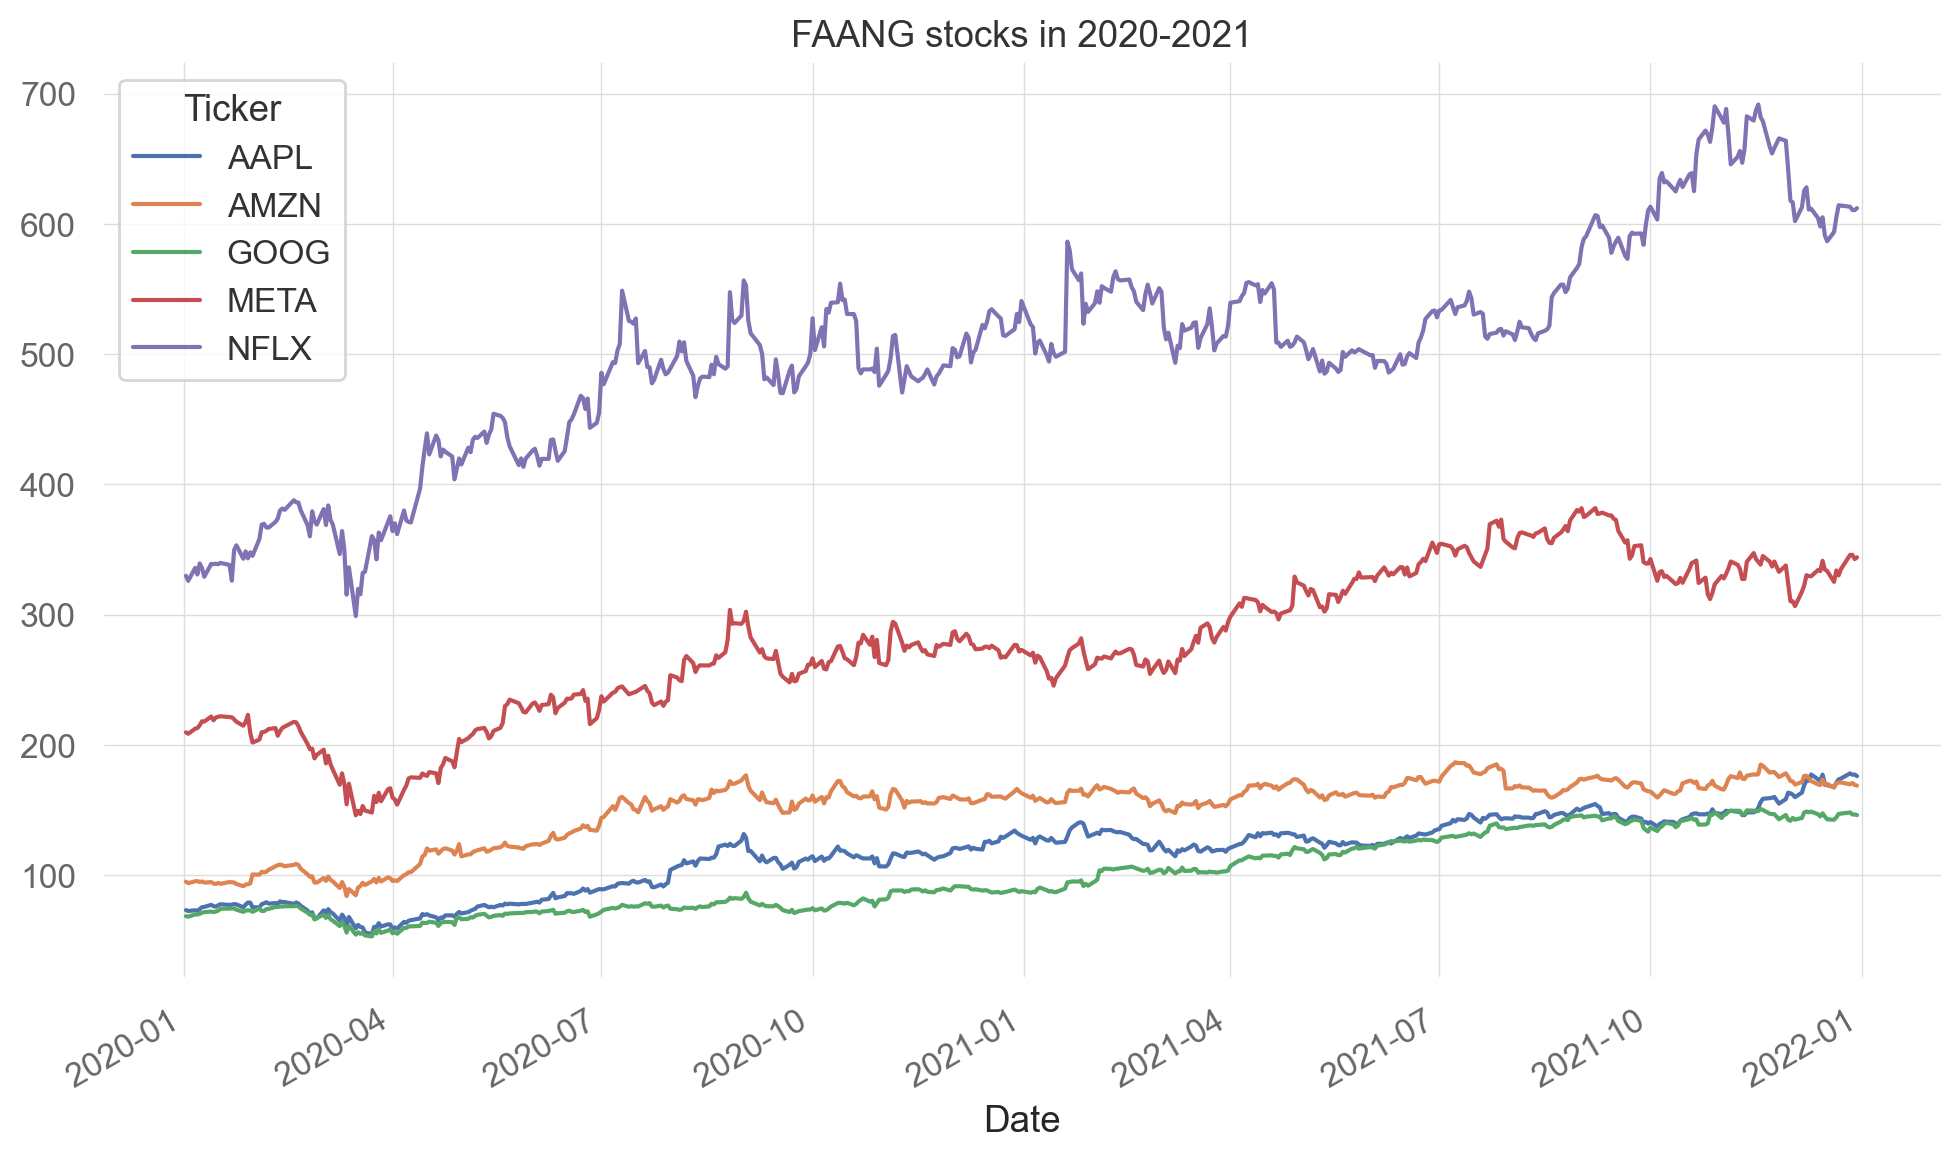

In [4]:
ASSETS = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]
n_assets = len(ASSETS)

prices_df = yf.download(ASSETS, 
                        start="2020-01-01", 
                        end="2021-12-31")
prices_df["Adj Close"].plot(title="FAANG stocks in 2020-2021")

sns.despine()
plt.tight_layout()


3. Calculate individual asset returns:

In [5]:
returns = prices_df["Adj Close"].pct_change().dropna()

4. Define the weights:

In [6]:
portfolio_weights = n_assets * [1 / n_assets]

5. Calculate portfolio returns:

In [7]:
portfolio_returns = pd.Series(
    np.dot(portfolio_weights, returns.T), 
    index=returns.index
)

6. Generate basic performance evaluation plots:

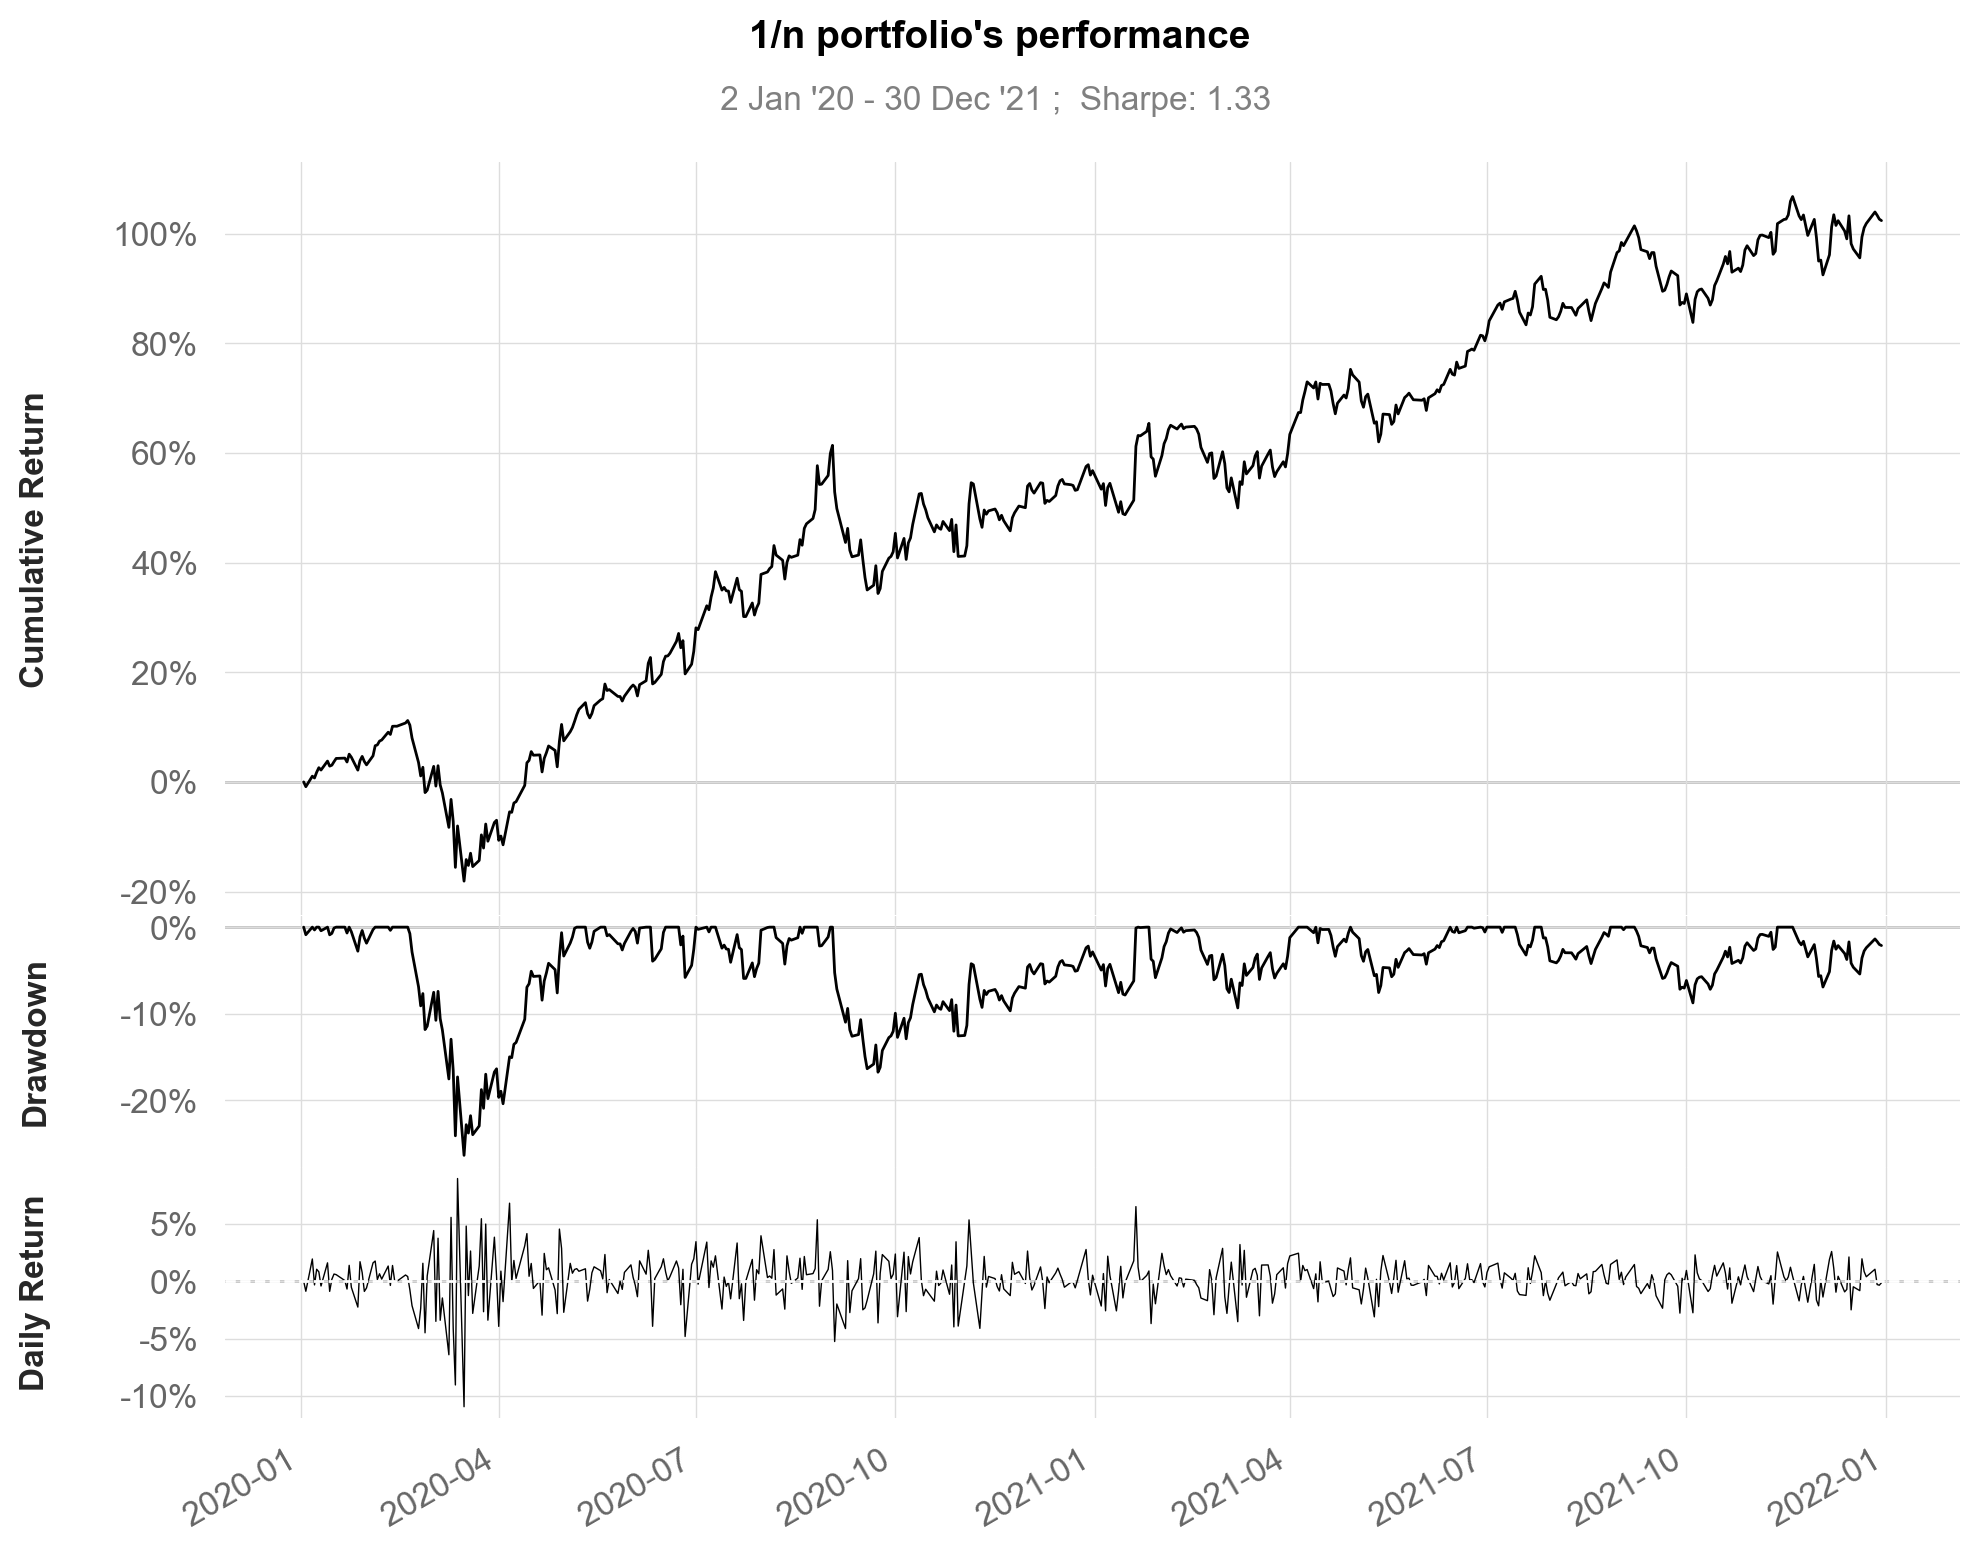

In [8]:
qs.plots.snapshot(portfolio_returns, 
                  title="1/n portfolio's performance", 
                  grayscale=True)

7. Calculate the basic portfolio evaluation metrics:

In [9]:
qs.reports.metrics(portfolio_returns, 
                   benchmark="SPY", 
                   mode="basic")

[*********************100%%**********************]  1 of 1 completed


                    Benchmark (SPY)    Strategy
------------------  -----------------  ----------
Start Period        2020-01-03         2020-01-03
End Period          2021-12-30         2021-12-30
Risk-Free Rate      0.0%               0.0%
Time in Market      100.0%             100.0%

Cumulative Return   47.69%             104.18%
CAGR﹪              14.47%             28.07%

Sharpe              0.9                1.34
Prob. Sharpe Ratio  89.13%             96.83%
Sortino             1.23               1.93
Sortino/√2          0.87               1.36
Omega               1.27               1.27

Max Drawdown        -34.1%             -26.35%
Longest DD Days     180                140

Gain/Pain Ratio     0.2                0.27
Gain/Pain (1M)      1.44               3.42

Payoff Ratio        0.79               0.84
Profit Factor       1.2                1.27
Common Sense Ratio  0.96               1.2
CPC Index           0.55               0.63
Tail Ratio          0.8                0

### There's more

1. Generate the full HTML tear sheet:

In [10]:
qs.reports.html(portfolio_returns, 
                benchmark="SPY", 
                title="1/n portfolio",
                download_filename="EW portfolio evaluation.html")

[*********************100%%**********************]  1 of 1 completed


2. Add the methods of `quantstats` to the `pandas` DataFrame:

In [11]:
qs.extend_pandas()

3. Calculate the Sharpe ratio and the Sortino ratio using the newly added methods:

In [12]:
print(f"Sharpe ratio: {portfolio_returns.sharpe():.2f}")
print(f"Sortino ratio: {portfolio_returns.sortino():.2f}")

Sharpe ratio: 1.33
Sortino ratio: 1.91


4. See all the new methods that are available to us thanks to the `quantstats` library:

In [13]:
[method for method in dir(qs.stats) if method[0] != "_"]

['adjusted_sortino',
 'autocorr_penalty',
 'avg_loss',
 'avg_return',
 'avg_win',
 'best',
 'cagr',
 'calmar',
 'common_sense_ratio',
 'comp',
 'compare',
 'compsum',
 'conditional_value_at_risk',
 'consecutive_losses',
 'consecutive_wins',
 'cpc_index',
 'cvar',
 'distribution',
 'drawdown_details',
 'expected_return',
 'expected_shortfall',
 'exposure',
 'gain_to_pain_ratio',
 'geometric_mean',
 'ghpr',
 'greeks',
 'implied_volatility',
 'information_ratio',
 'kelly_criterion',
 'kurtosis',
 'max_drawdown',
 'monthly_returns',
 'omega',
 'outlier_loss_ratio',
 'outlier_win_ratio',
 'outliers',
 'payoff_ratio',
 'pct_rank',
 'probabilistic_adjusted_sortino_ratio',
 'probabilistic_ratio',
 'probabilistic_sharpe_ratio',
 'probabilistic_sortino_ratio',
 'profit_factor',
 'profit_ratio',
 'r2',
 'r_squared',
 'rar',
 'recovery_factor',
 'remove_outliers',
 'risk_of_ruin',
 'risk_return_ratio',
 'rolling_greeks',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'ror',
 'seren

5. Generate the plots:

[*********************100%%**********************]  1 of 1 completed


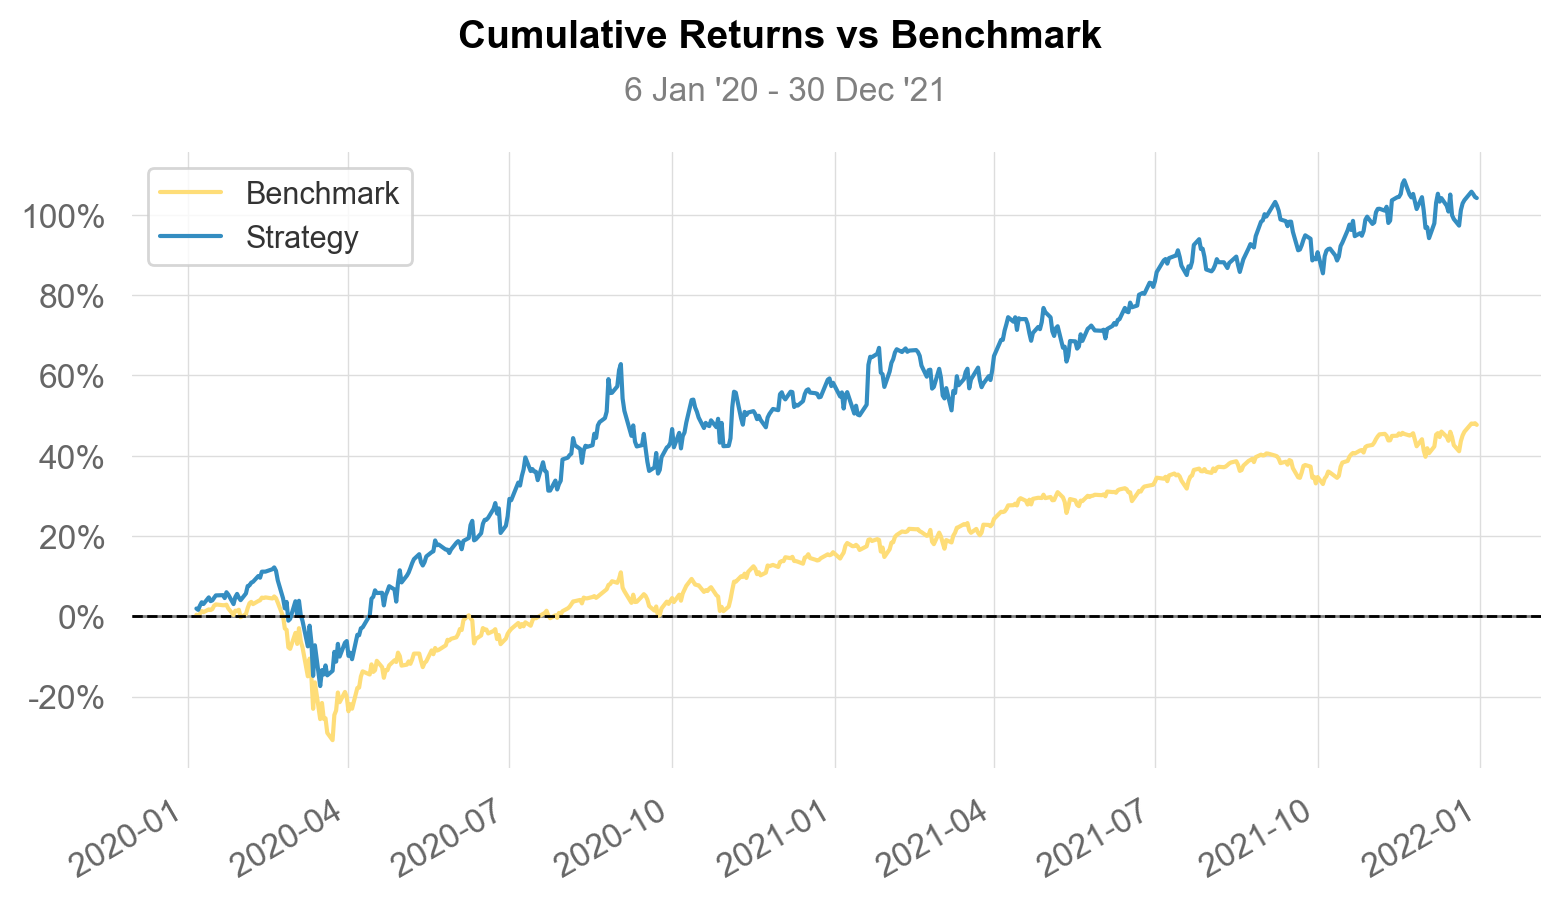

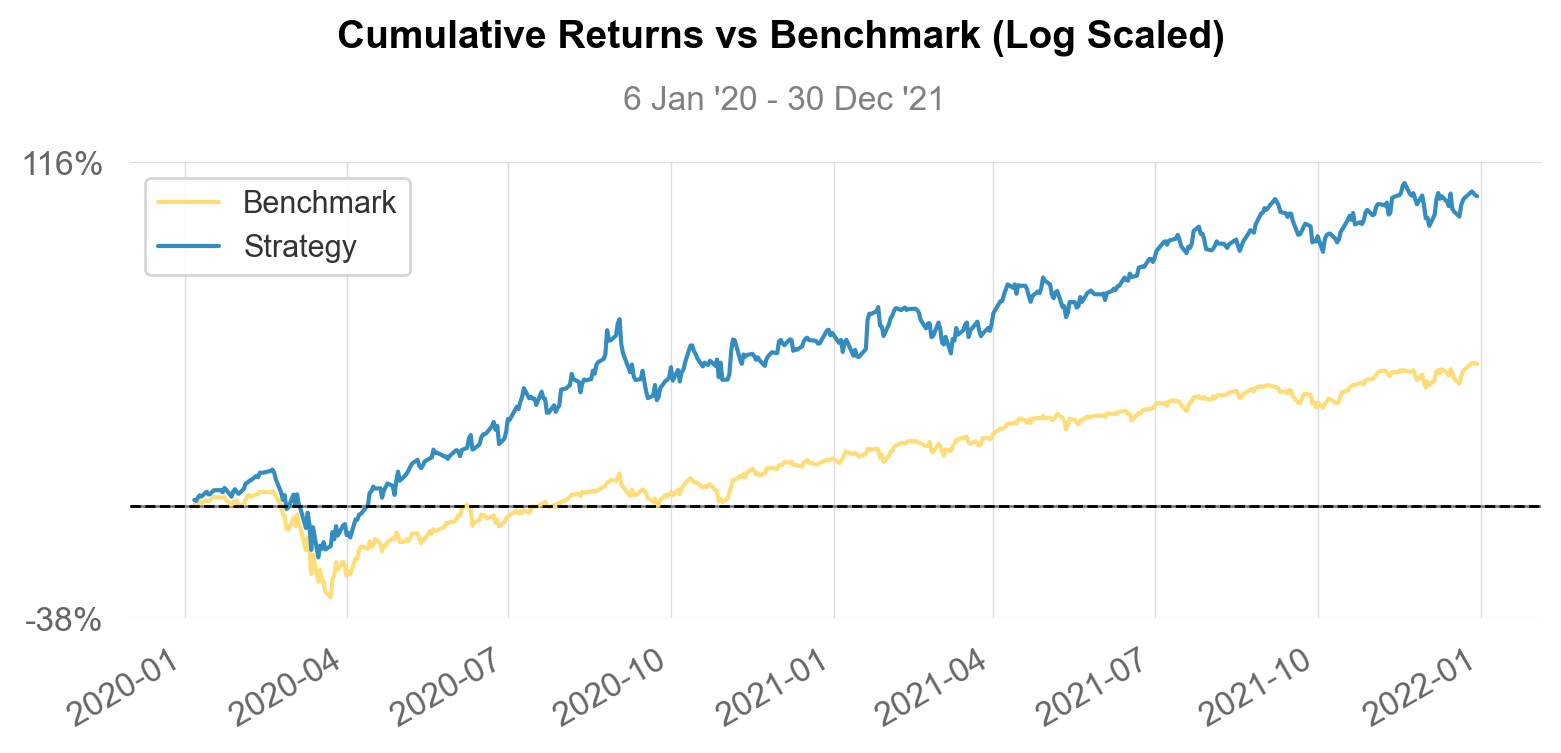

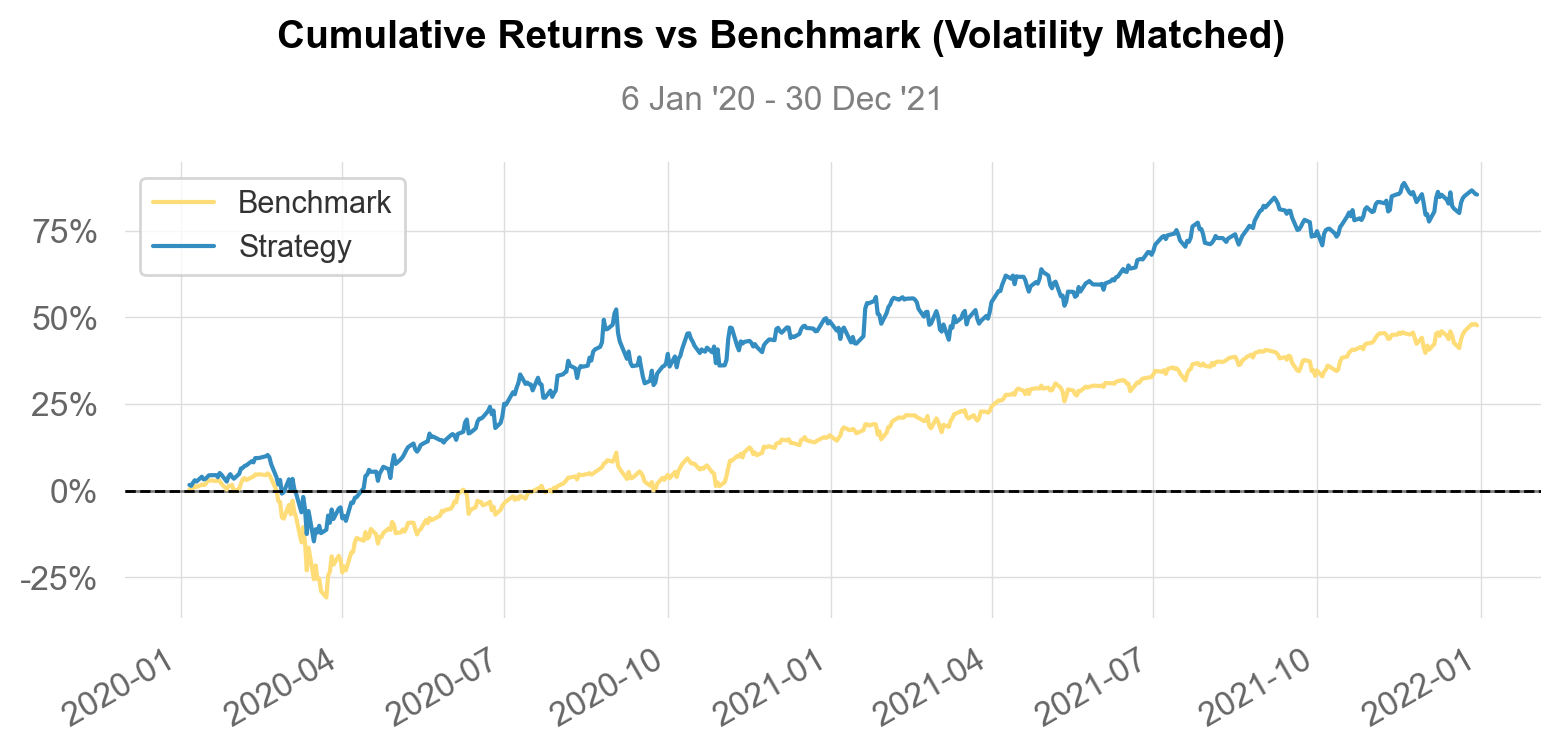

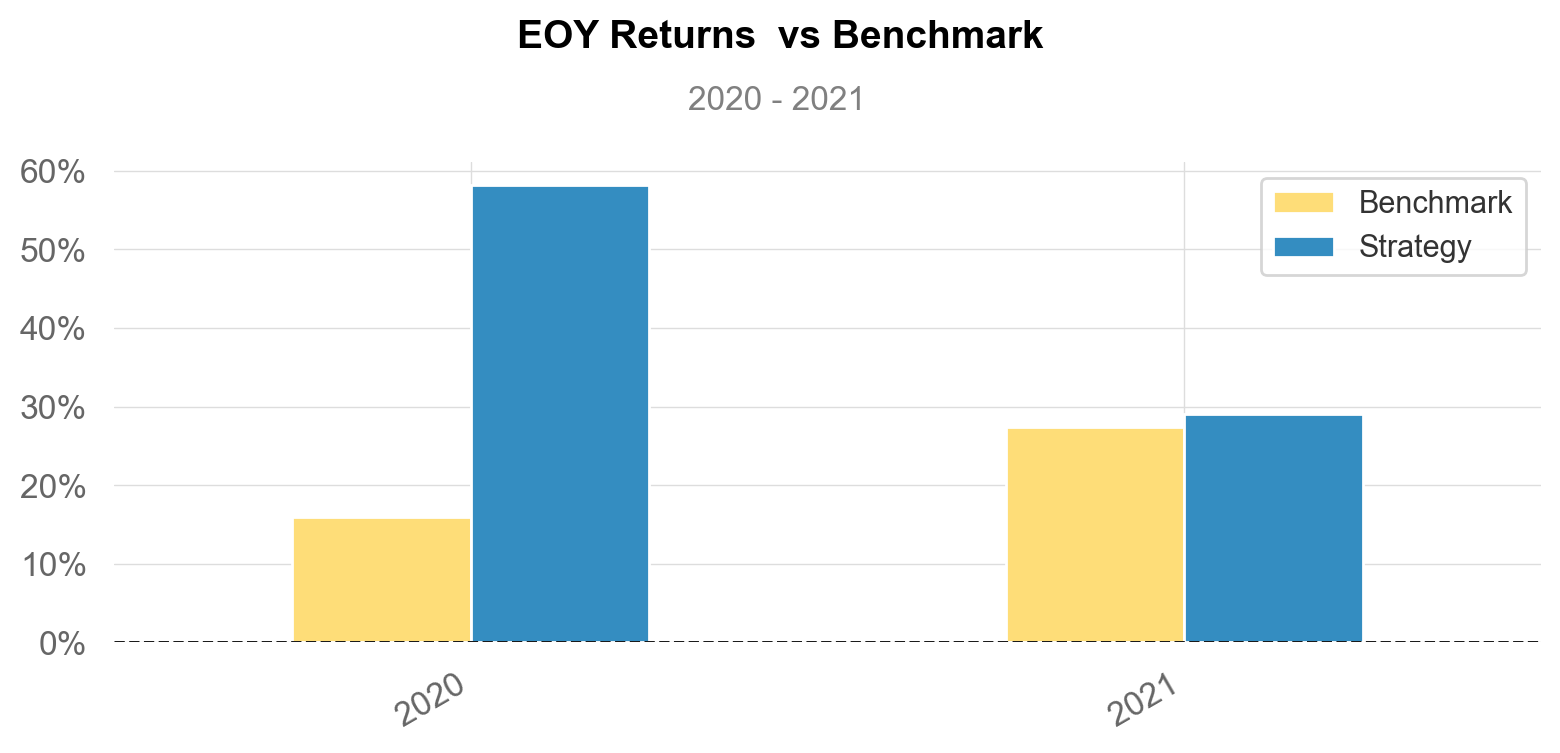

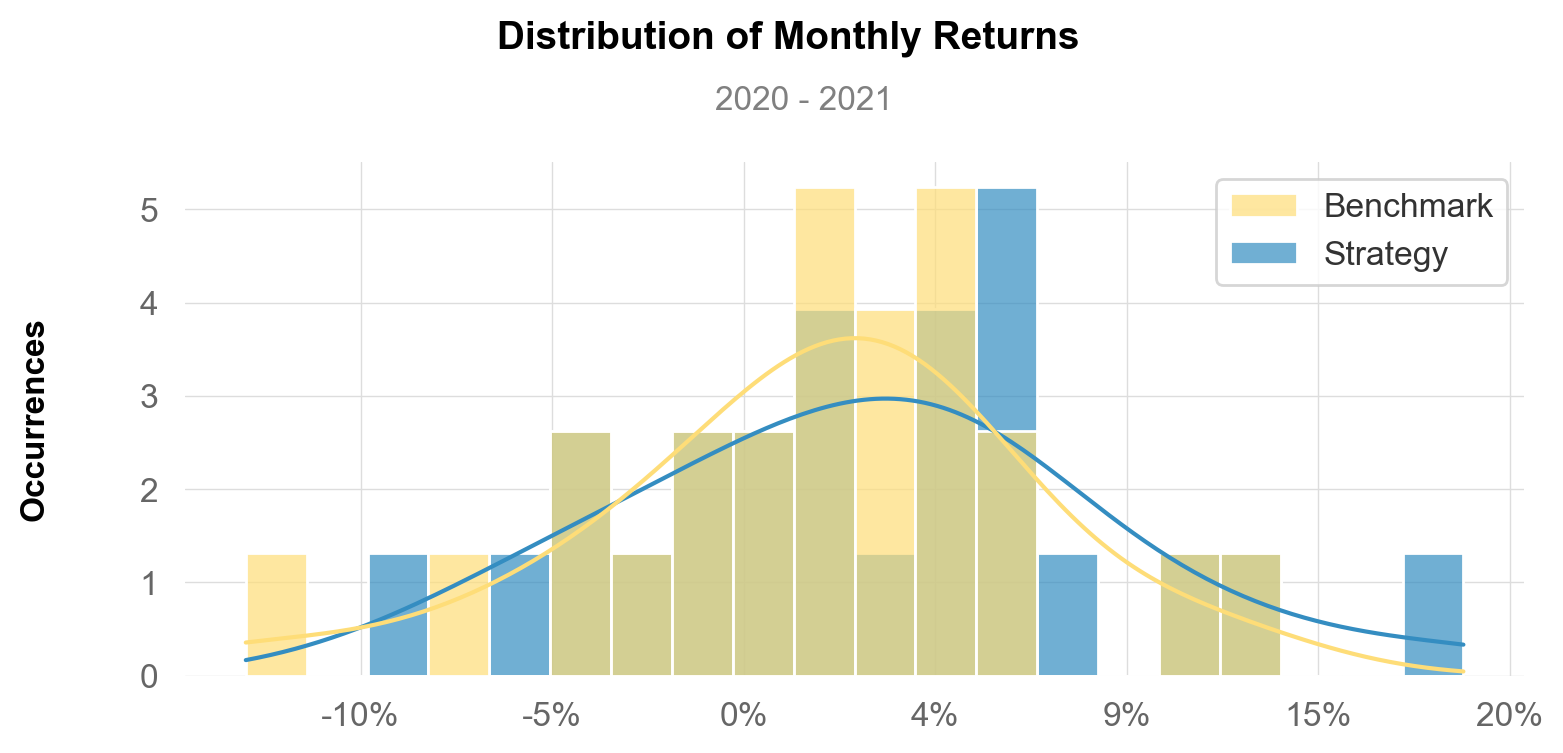

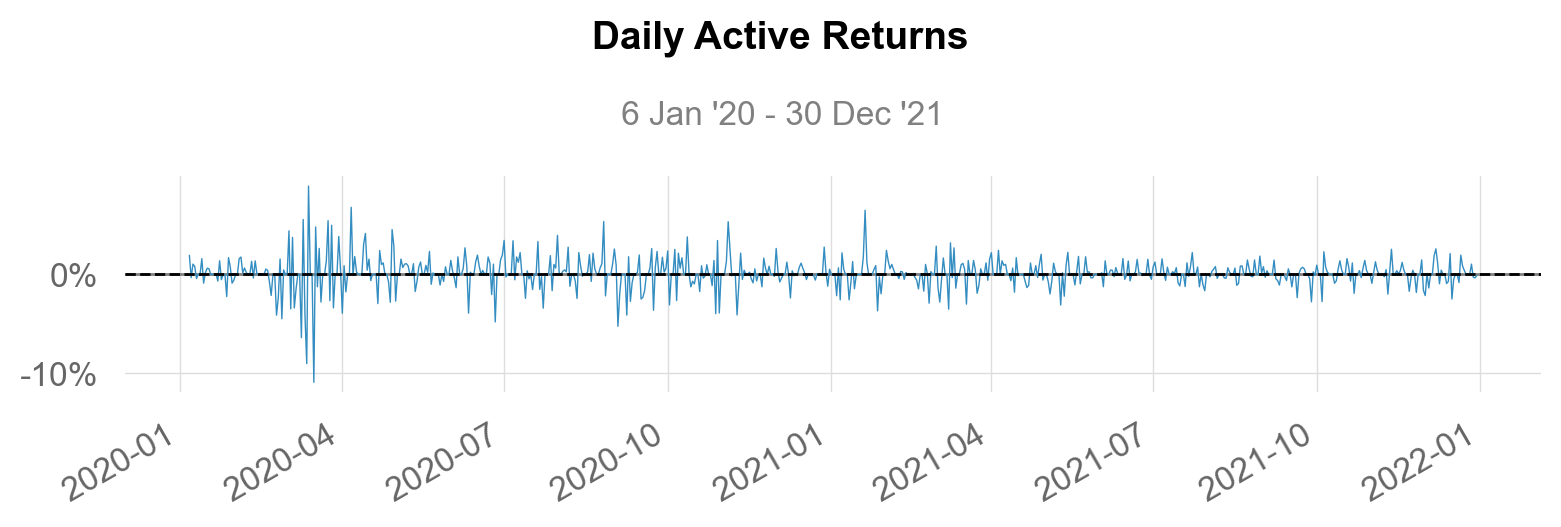

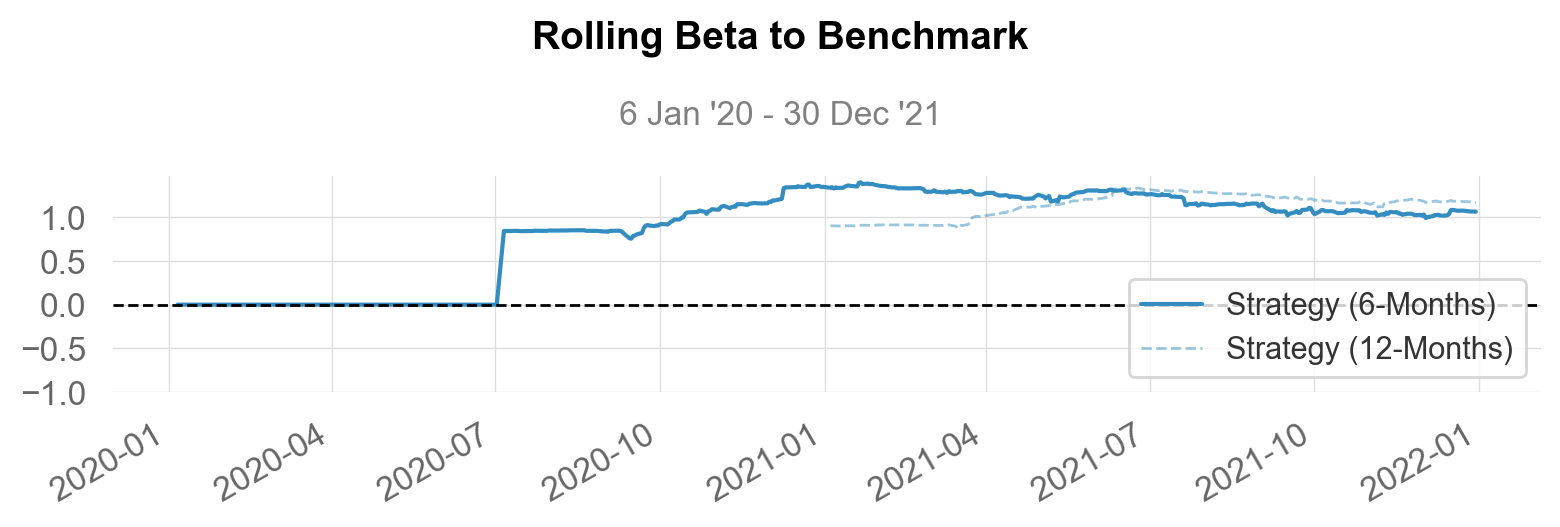

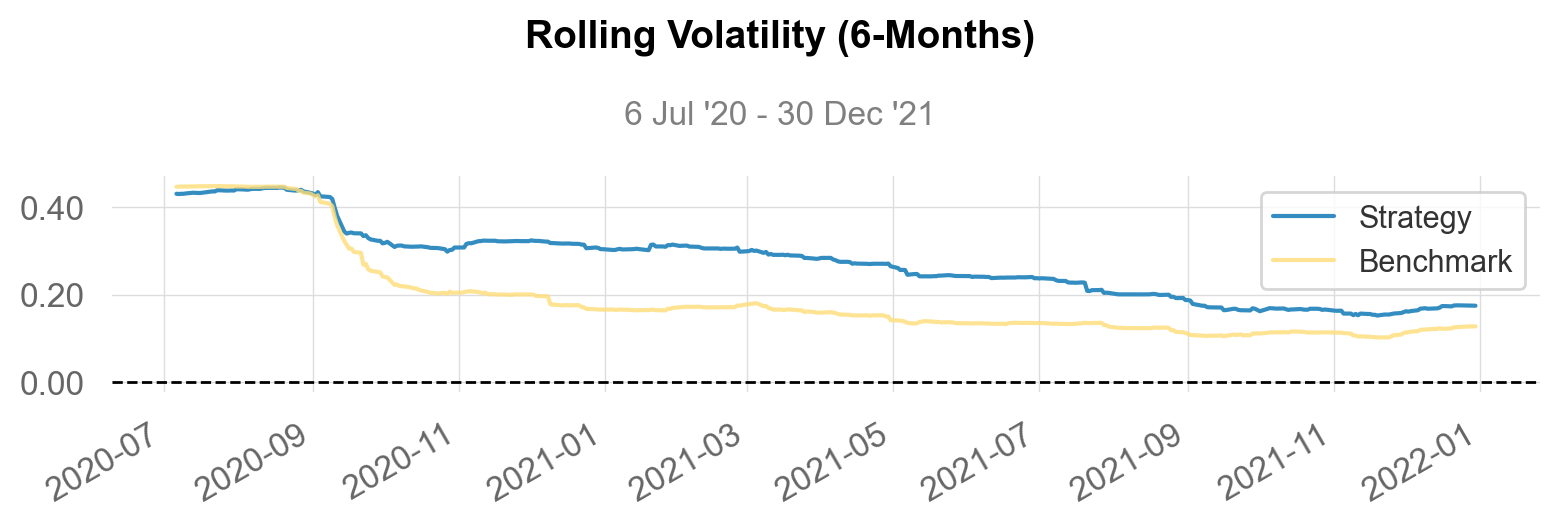

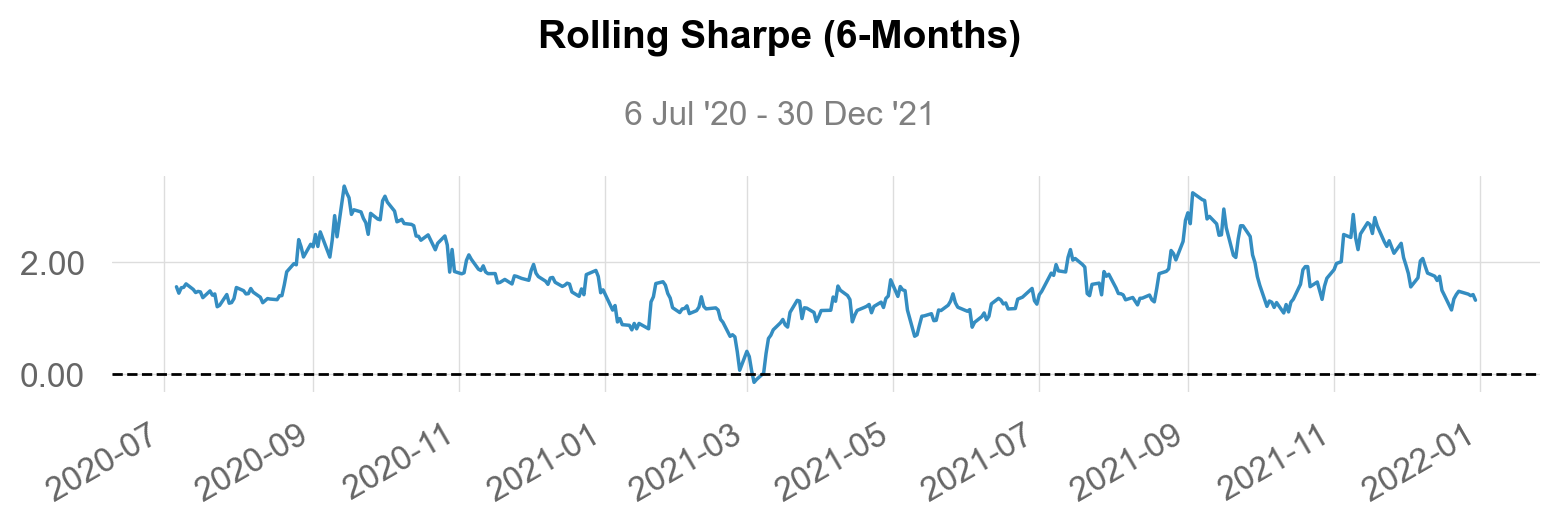

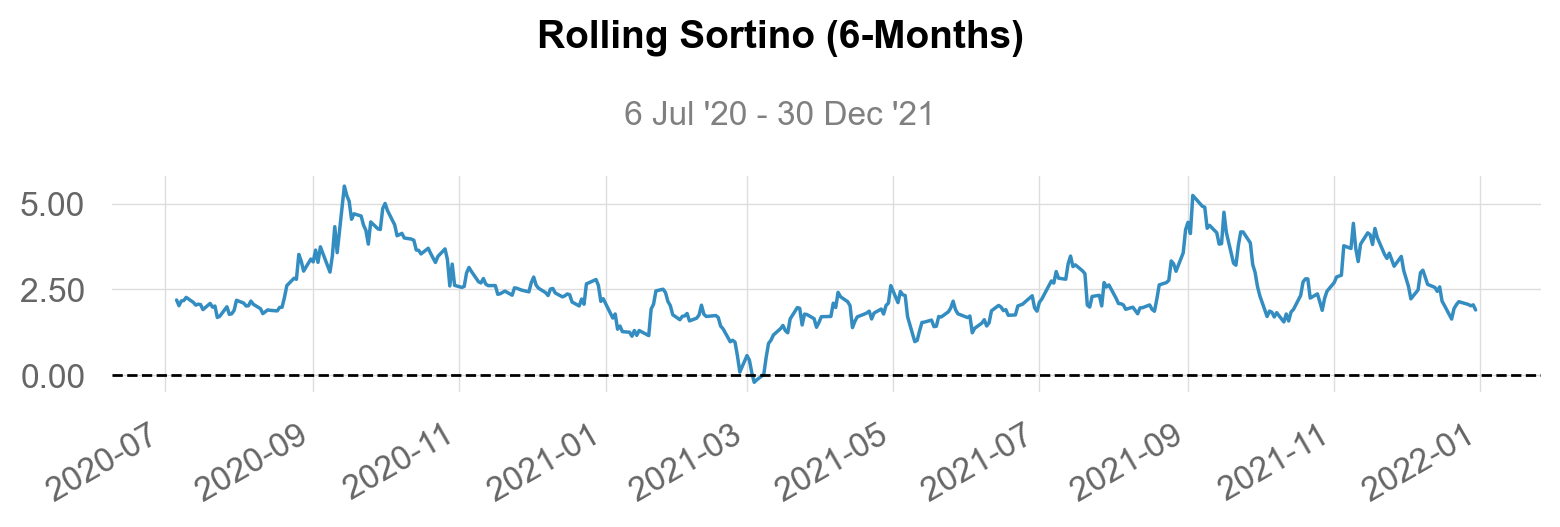

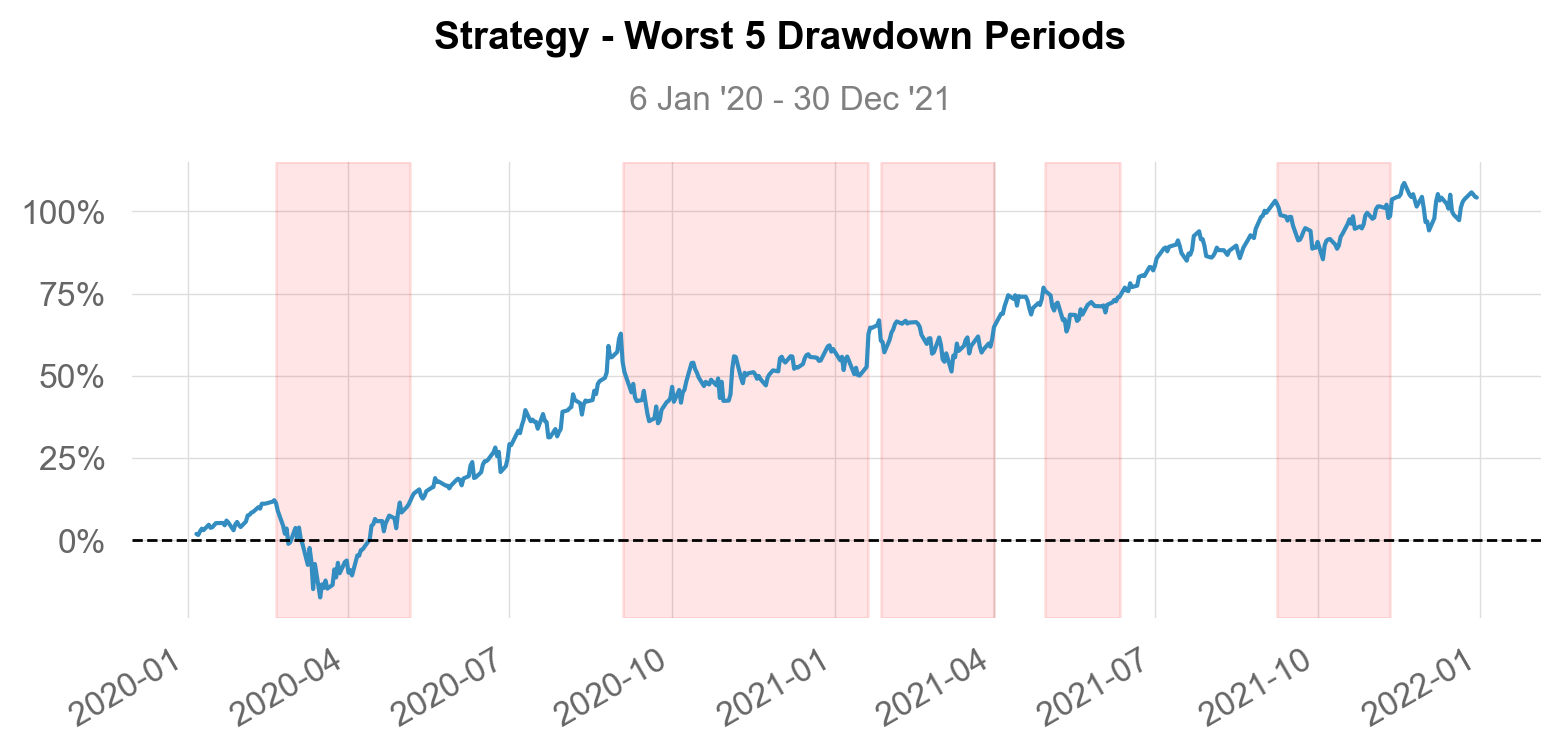

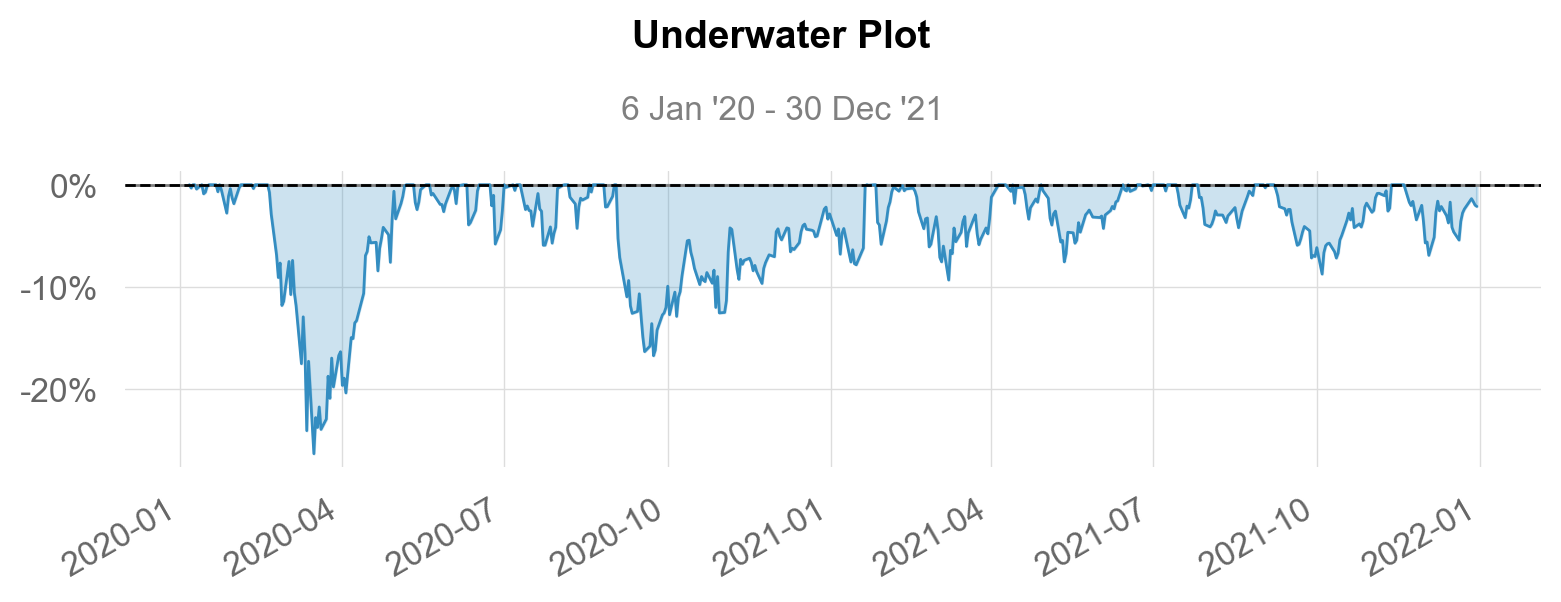

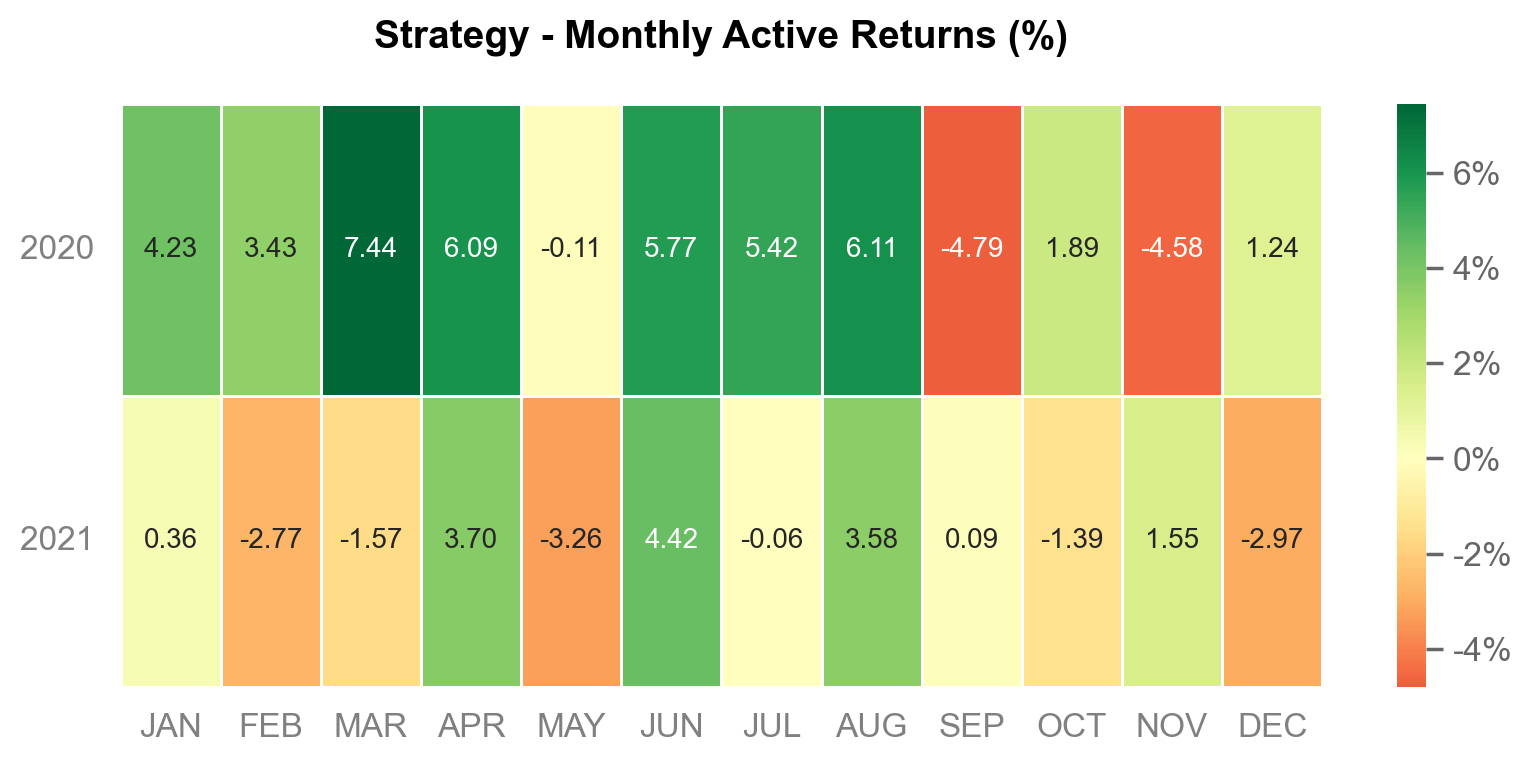

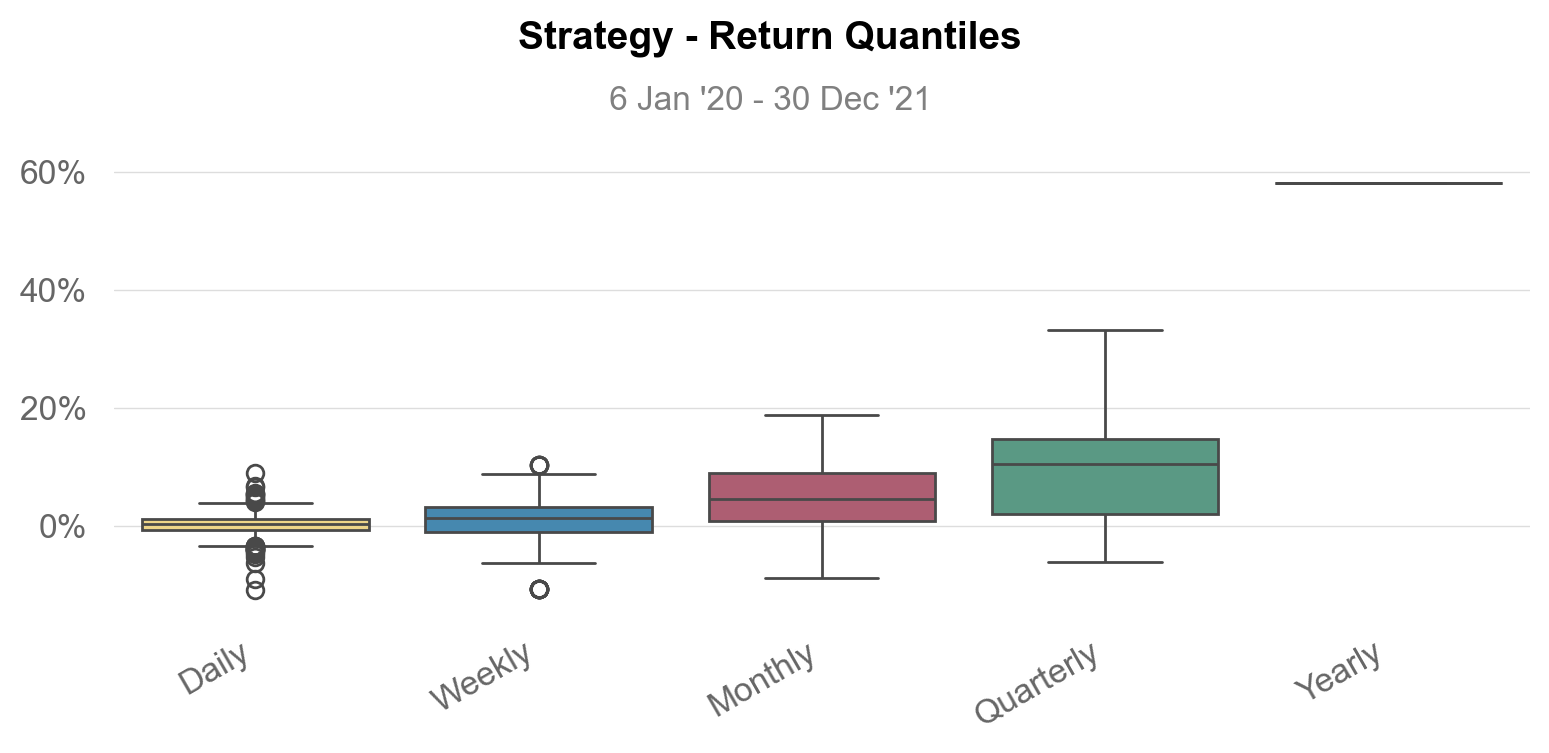

In [14]:
qs.reports.plots(portfolio_returns, benchmark="SPY", mode="full", prepare_returns=False)

In [15]:
help(portfolio_returns.value_at_risk)

Help on method value_at_risk in module quantstats.stats:

value_at_risk(sigma=1, confidence=0.95, prepare_returns=True) method of pandas.core.series.Series instance
    Calculats the daily value-at-risk
    (variance-covariance calculation with confidence n)



## 11.2 Finding the efficient frontier using Monte Carlo simulations

### How to do it...

1. Import the libraries:

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [17]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
ASSETS = ["META", "TSLA", "MSFT"]
ASSETS.sort()

n_assets = len(ASSETS)

3. Download the stock prices from Yahoo Finance:

In [18]:
prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31")

[*********************100%%**********************]  3 of 3 completed


In [19]:
prices_df.head()

Price        Adj Close                               Close              \
Ticker            META        MSFT        TSLA        META        MSFT   
Date                                                                     
2021-01-04  268.654968  211.605286  243.256668  268.940002  217.690002   
2021-01-05  270.682800  211.809402  245.036667  270.970001  217.899994   
2021-01-06  263.030914  206.317352  251.993332  263.309998  212.250000   
2021-01-07  268.455170  212.188538  272.013336  268.739990  218.289993   
2021-01-08  267.286407  213.481369  293.339996  267.570007  219.619995   

Price                         High                                 Low  \
Ticker            TSLA        META        MSFT        TSLA        META   
Date                                                                     
2021-01-04  243.256668  275.000000  223.000000  248.163330  265.200012   
2021-01-05  245.036667  272.399994  218.520004  246.946671  268.209991   
2021-01-06  251.993332  267.750000  216.490005  258.000000  260.010010   
2021-01-07  272.013336  271.609985  219.339996  272.329987  264.779999   
2021-01-08  293.339996  268.950012  220.580002  294.829987  263.179993   

Price                                     Open                          \
Ticker            MSFT        TSLA        META        MSFT        TSLA   
Date                                                                     
2021-01-04  214.809998  239.063339  274.779999  222.529999  239.820007   
2021-01-05  215.699997  239.733337  268.290009  217.259995  241.220001   
2021-01-06  211.940002  249.699997  262.000000  212.169998  252.830002   
2021-01-07  213.710007  258.399994  265.899994  214.039993  259.209991   
2021-01-08  217.029999  279.463318  268.309998  218.679993  285.333344   

Price         Volume                       
Ticker          META      MSFT       TSLA  
Date                                       
2021-01-04  15106100  37130100  145914600  
2021-01-05   9871600  23823000   96735600  
2021-01-06  24354100  35930700  134100000  
2021-01-07  15789800  27694500  154496700  
2021-01-08  18528300  22956200  225166500

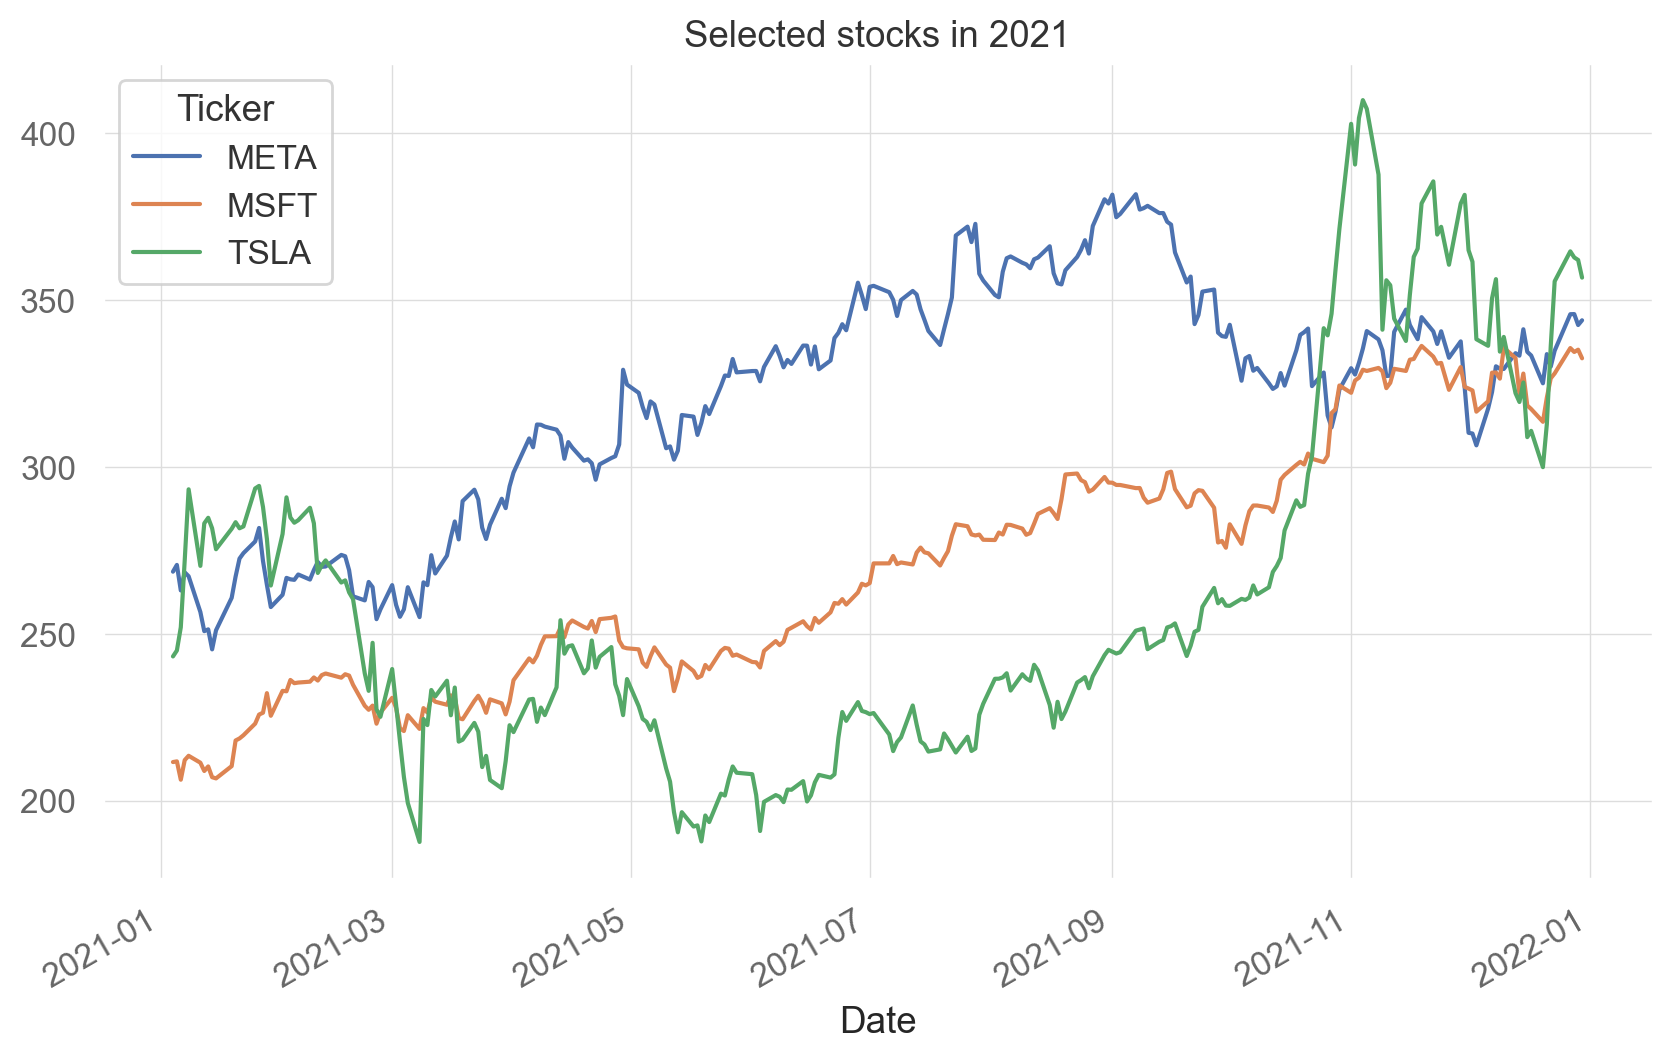

In [20]:
prices_df["Adj Close"].plot(title="Selected stocks in 2021");

4. Calculate annualized average returns and the corresponding standard deviation:

In [21]:
returns_df = prices_df["Adj Close"].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

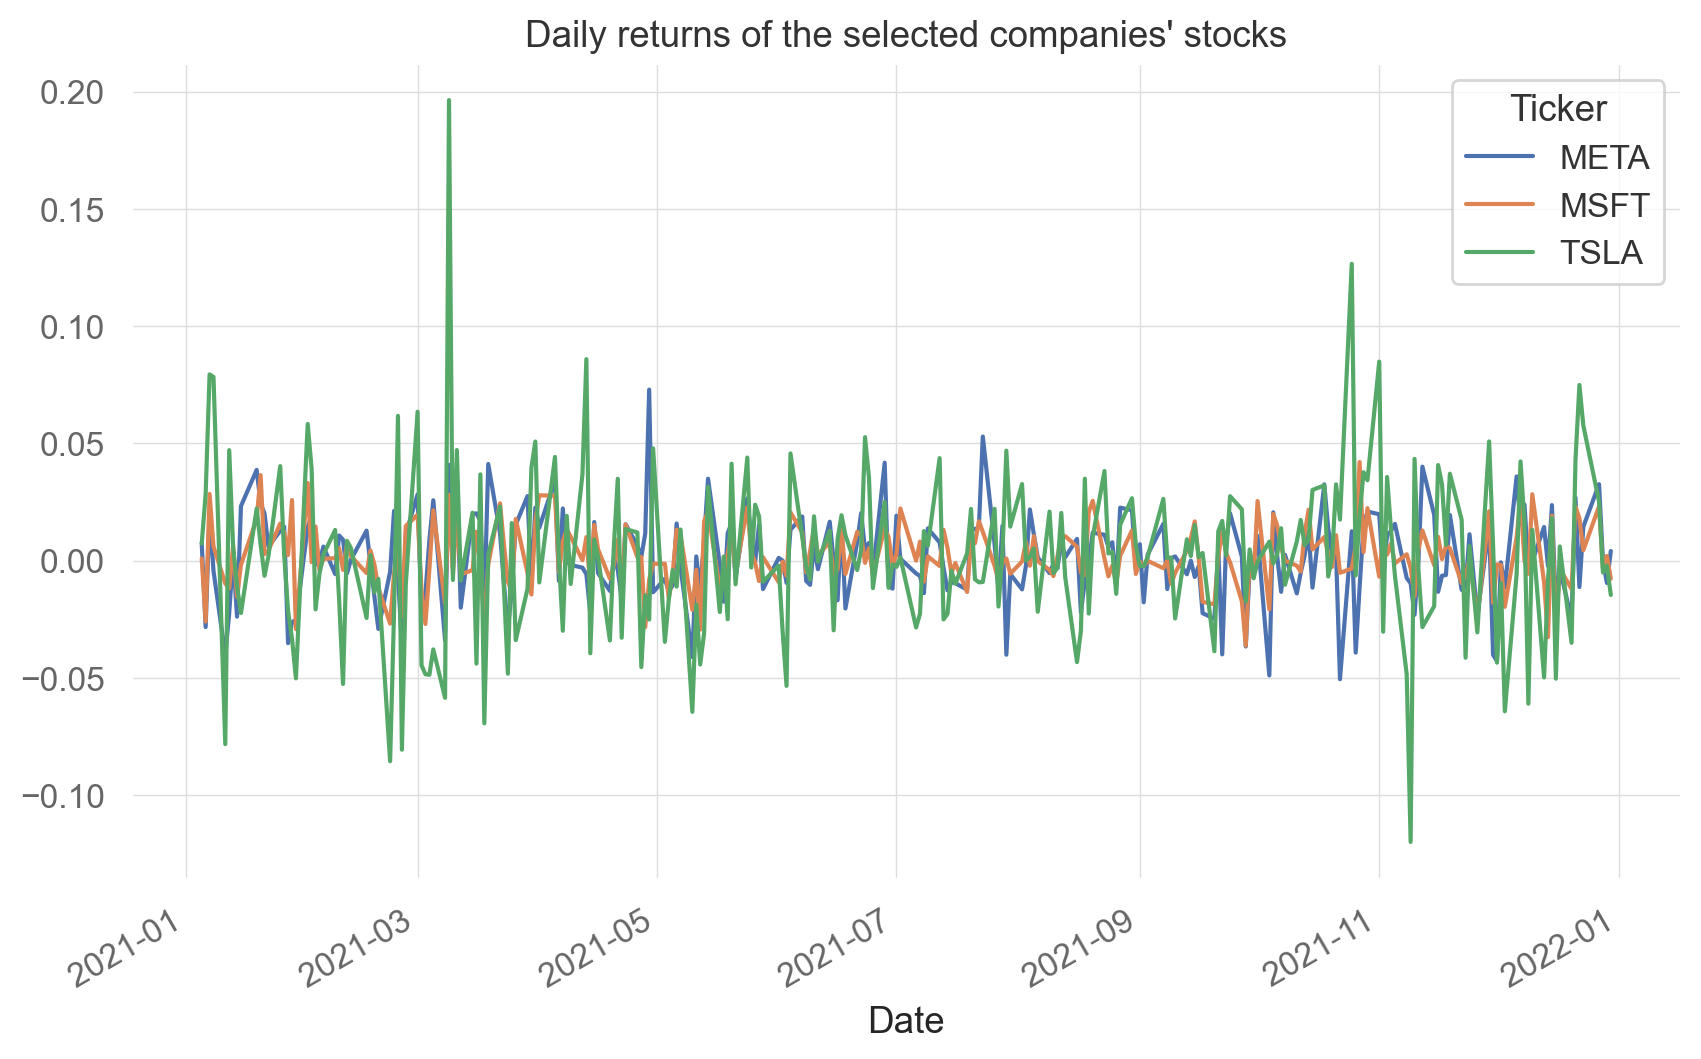

In [22]:
returns_df.plot(title="Daily returns of the selected companies' stocks");

5. Simulate random portfolio weights:

In [23]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate the portfolio metrics:

In [24]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(
        np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    )
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a DataFrame containing all the data: 

In [25]:
portf_results_df = pd.DataFrame(
    {"returns": portf_rtns,
     "volatility": portf_vol,
     "sharpe_ratio": portf_sharpe_ratio}
)
portf_results_df

returns  volatility  sharpe_ratio
0      0.464339    0.278617      1.666587
1      0.365851    0.262762      1.392327
2      0.493183    0.291326      1.692890
3      0.432875    0.371864      1.164070
4      0.360613    0.260929      1.382034
...         ...         ...           ...
99995  0.510247    0.393315      1.297299
99996  0.423330    0.325001      1.302551
99997  0.469532    0.277079      1.694576
99998  0.402106    0.317652      1.265869
99999  0.422494    0.350263      1.206218

[100000 rows x 3 columns]

8. Locate the points creating the Efficient Frontier:

In [26]:
N_POINTS = 100

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(
    portf_results_df["returns"].min(), 
    portf_results_df["returns"].max(), 
    N_POINTS
)
possible_ef_rtns = np.round(possible_ef_rtns, 2)    
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))

9. Plot the Efficient Frontier:

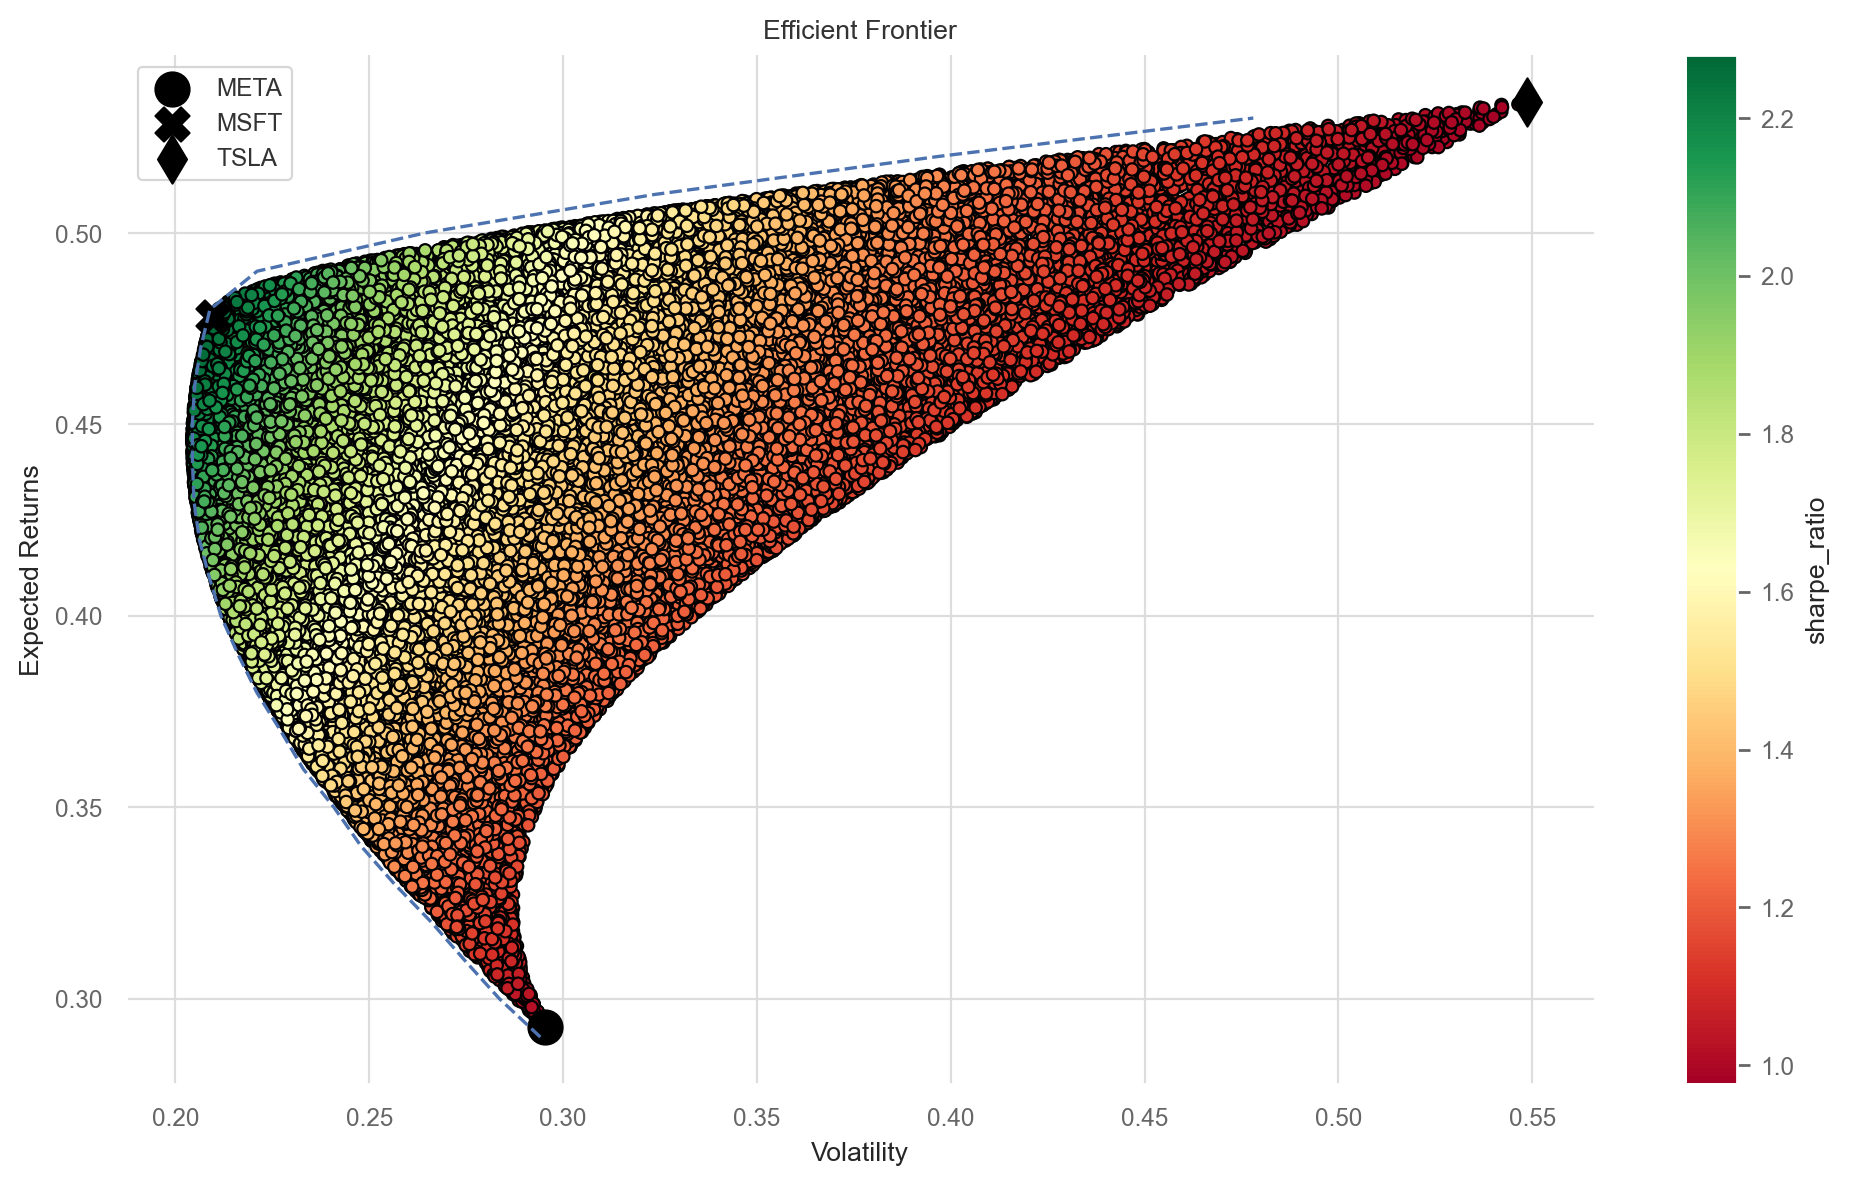

In [27]:
MARKERS = ["o", "X", "d", "*"]

with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.plot(ef_vol_list, ef_rtn_list, "b--")
    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                   y=avg_returns[asset_index], 
                   marker=MARKERS[asset_index], 
                   s=150, color="black",
                   label=ASSETS[asset_index])
    ax.legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_10", dpi=200)

### There's more

In [28]:
from chapter_11_utils import print_portfolio_summary

In [29]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df["volatility"])
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [30]:
print_portfolio_summary(max_sharpe_portf, 
                        weights[max_sharpe_ind], 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
returns: 47.88% volatility: 21.01% sharpe_ratio: 227.96% 
Weights
META: 0.04% MSFT: 98.57% TSLA: 1.39% 

In [31]:
print_portfolio_summary(min_vol_portf, 
                        weights[min_vol_ind], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
returns: 44.59% volatility: 20.43% sharpe_ratio: 218.20% 
Weights
META: 17.42% MSFT: 82.52% TSLA: 0.07% 

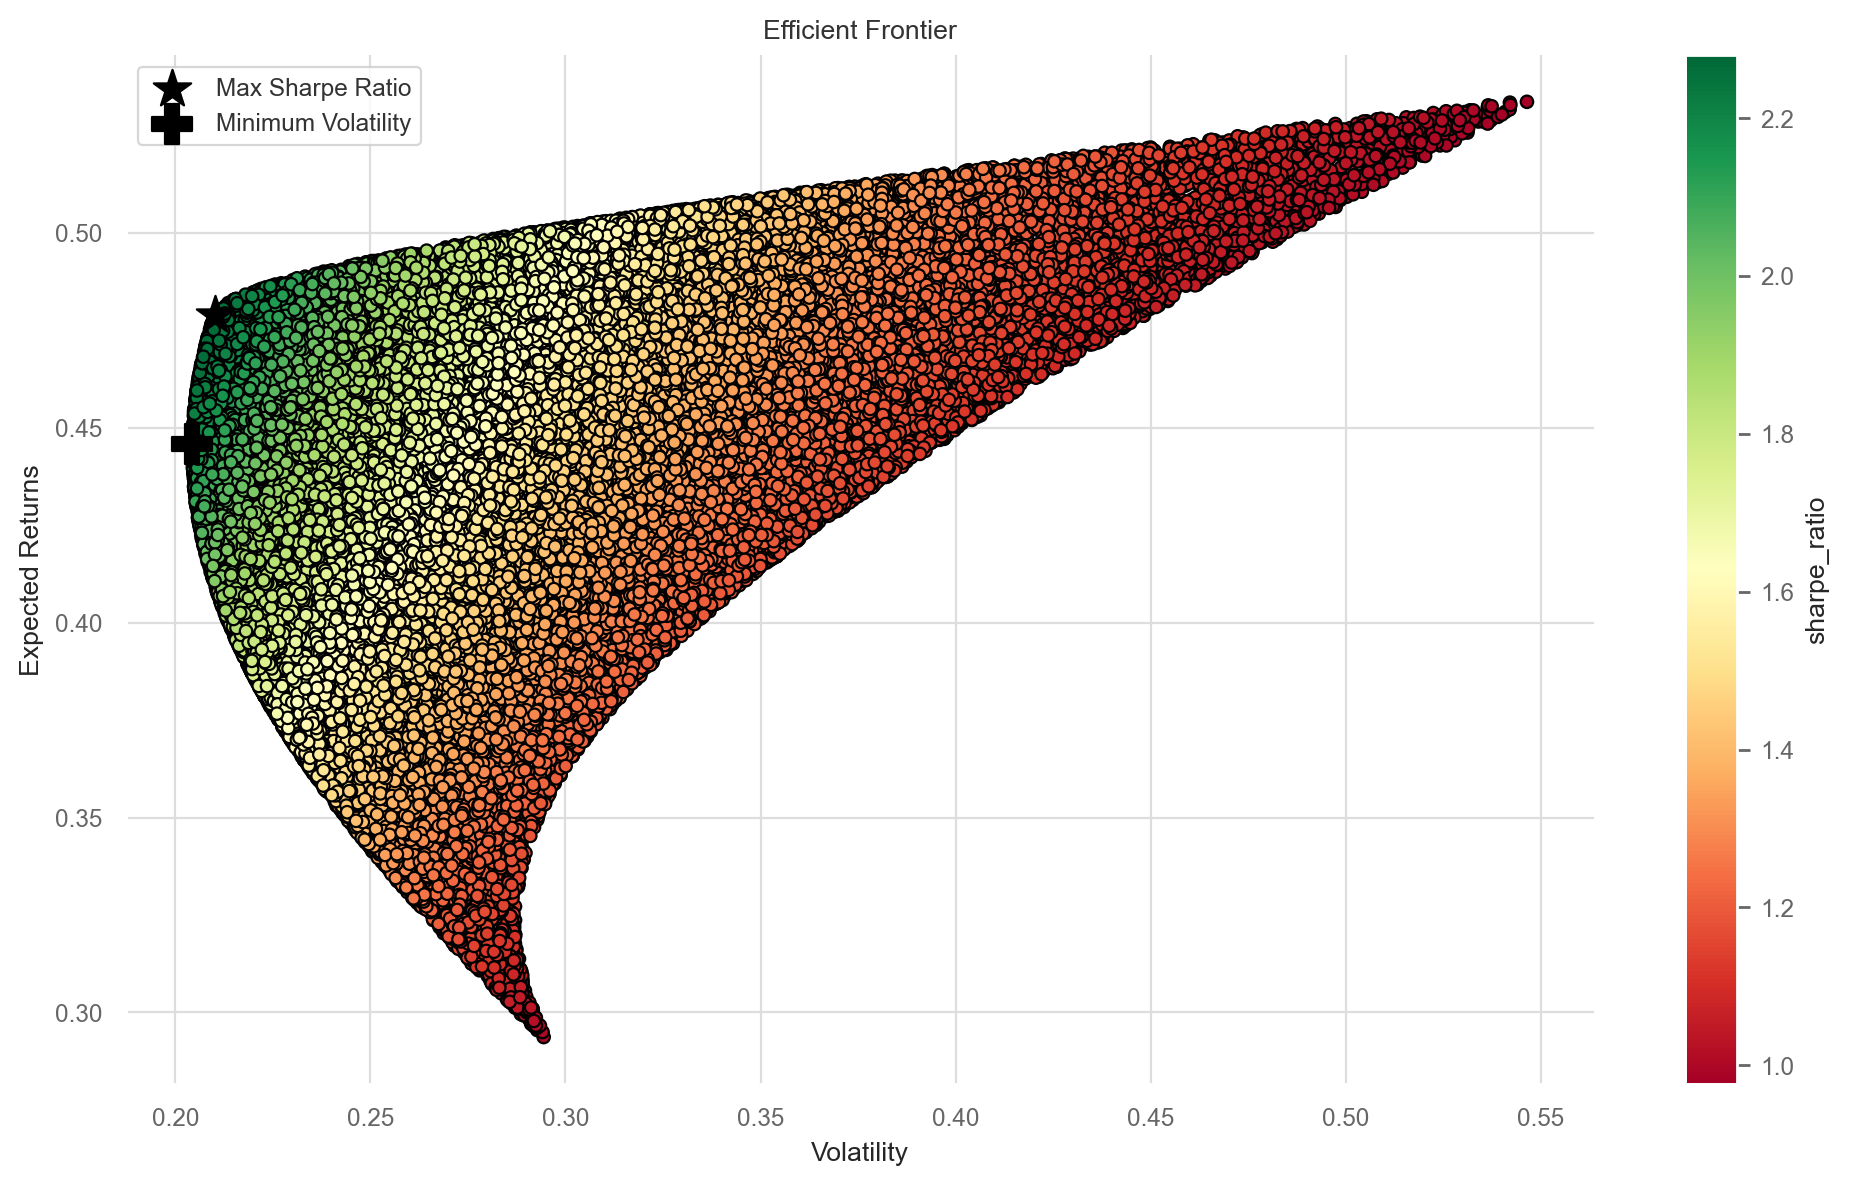

In [32]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.scatter(x=max_sharpe_portf["volatility"], 
               y=max_sharpe_portf["returns"], 
               c="black", marker="*", 
               s=200, label="Max Sharpe Ratio")
    ax.scatter(x=min_vol_portf["volatility"], 
               y=min_vol_portf["returns"], 
               c="black", marker="P", 
               s=200, label="Minimum Volatility")
    ax.set(xlabel="Volatility", ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_11", dpi=200)

## 11.3 Finding the efficient frontier using optimization with `scipy`

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations*.

### How to do it...

1. Import the libraries:

In [33]:
import numpy as np
import scipy.optimize as sco
from chapter_11_utils import print_portfolio_summary

2. Define functions calculating portfolio returns and volatility:

In [34]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

3. Define the function calculating the efficient frontier:

In [35]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constr = (
            {"type": "eq", 
             "fun": lambda x: get_portf_rtn(x, avg_rtns) - ret},
            {"type": "eq", 
             "fun": lambda x: np.sum(x) - 1}
        )
        ef_portf = sco.minimize(get_portf_vol, 
                                initial_guess, 
                                args=args, method="SLSQP", 
                                constraints=constr,
                                bounds=bounds)
        efficient_portfolios.append(ef_portf)
    
    return efficient_portfolios

4. Define the considered range of expected portfolio returns:

In [36]:
rtns_range = np.linspace(-0.1, 0.55, 200)

5. Calculate the Efficient Frontier:

In [37]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [38]:
vols_range = [x["fun"] for x in efficient_portfolios]

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

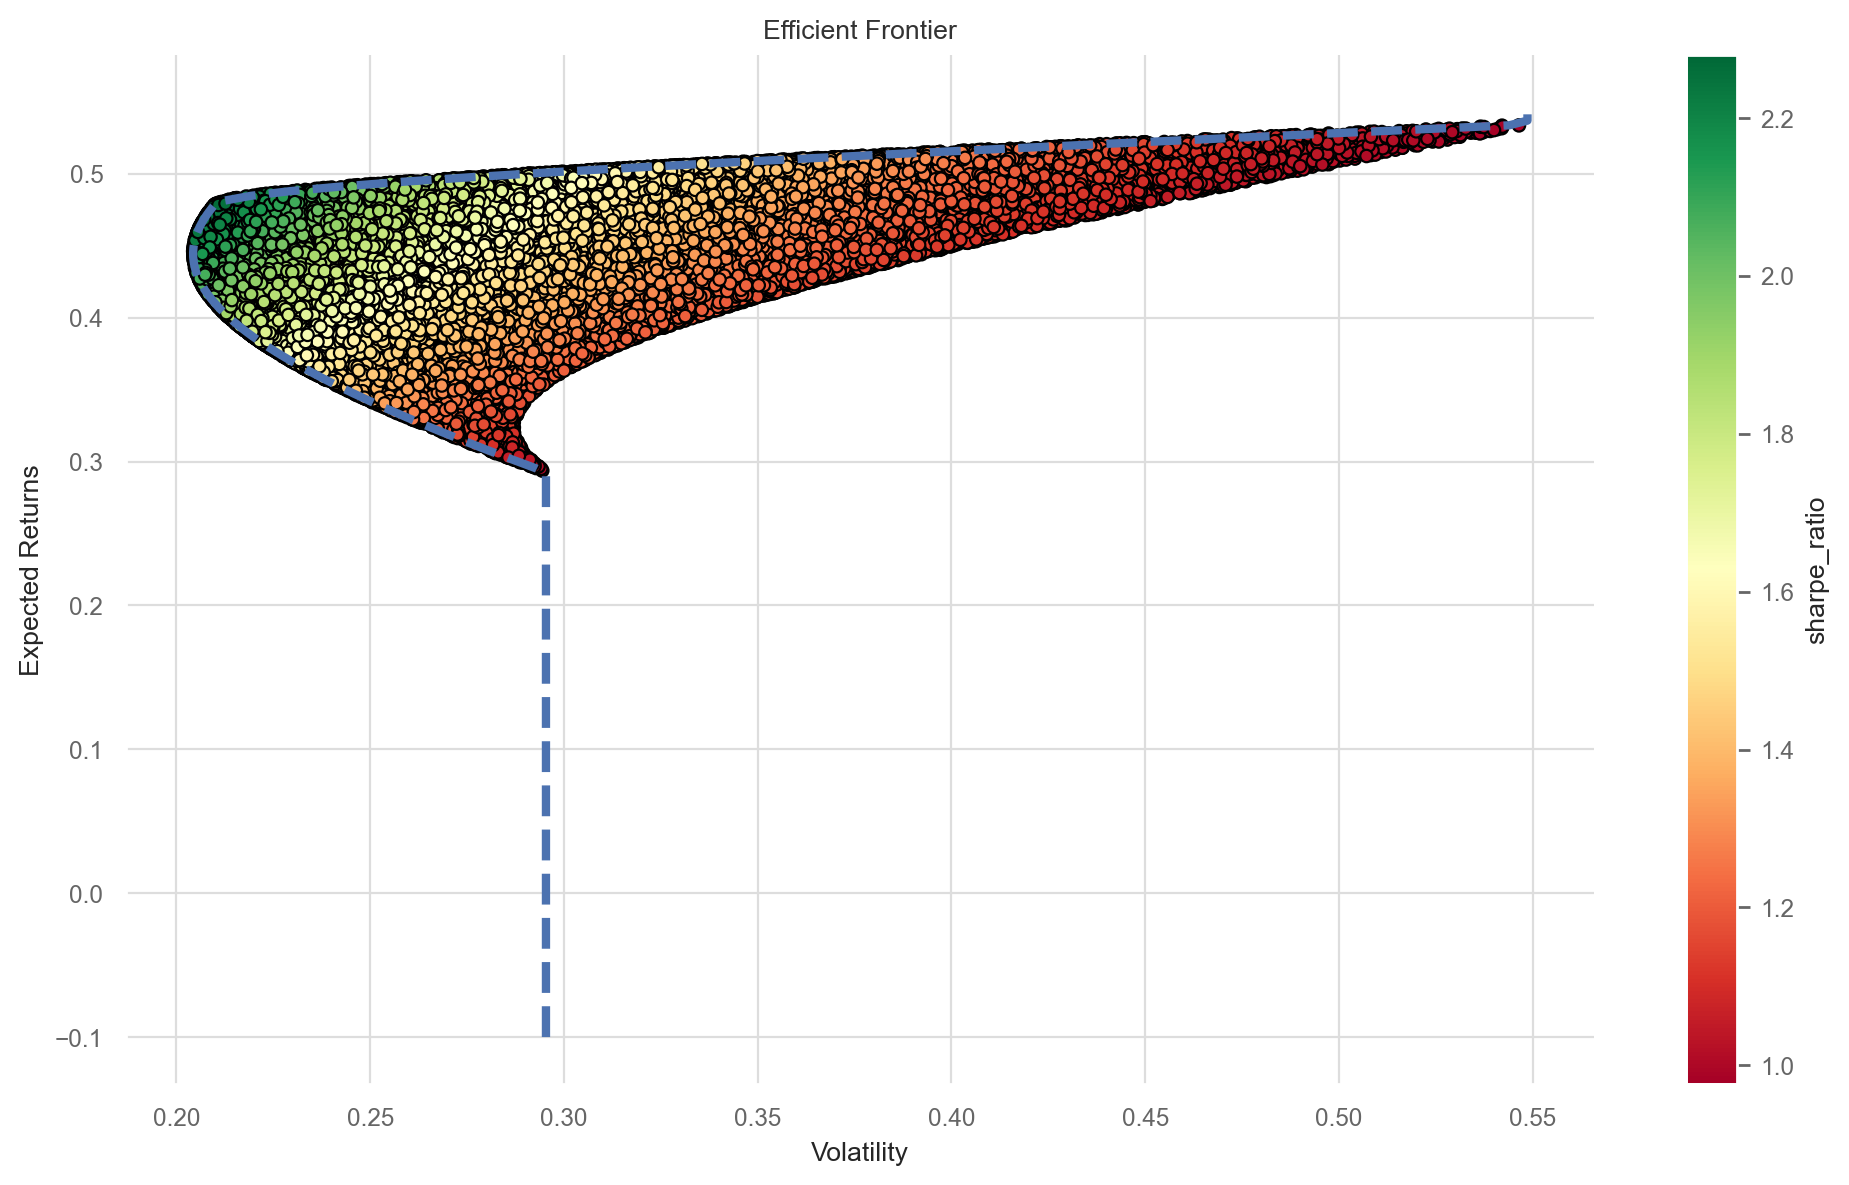

In [39]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.plot(vols_range, rtns_range, "b--", linewidth=3)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_12", dpi=200)

8. Identify the minimum volatility portfolio:

In [40]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]["fun"]

min_vol_portf = {
    "Return": min_vol_portf_rtn,
    "Volatility": min_vol_portf_vol,
    "Sharpe Ratio": (min_vol_portf_rtn / min_vol_portf_vol)
}

min_vol_portf

{'Return': 0.4454773869346734,
 'Volatility': 0.2043182515984645,
 'Sharpe Ratio': 2.1803112715066972}

9. Print the performance summary:

In [41]:
print_portfolio_summary(min_vol_portf, 
                        efficient_portfolios[min_vol_ind]["x"], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
Return: 44.55% Volatility: 20.43% Sharpe Ratio: 218.03% 
Weights
META: 17.61% MSFT: 82.39% TSLA: 0.00% 

### There's more

1. Define the new objective function (negative Sharpe ratio): 

In [42]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (
        (portf_returns - rf_rate) / portf_volatility
    )
    return -portf_sharpe_ratio

2. Find the optimized portfolio:

In [43]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({"type": "eq", 
                "fun": lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method="SLSQP", 
                                bounds=bounds, 
                                constraints=constraints)

3. Extract information about the maximum Sharpe Ratio portfolio:

In [44]:
max_sharpe_portf_w = max_sharpe_portf["x"]
max_sharpe_portf = {
    "Return": get_portf_rtn(max_sharpe_portf_w, avg_returns),
    "Volatility": get_portf_vol(max_sharpe_portf_w, 
                                avg_returns, 
                                cov_mat),
    "Sharpe Ratio": -max_sharpe_portf["fun"]
}
max_sharpe_portf

{'Return': 0.4786635716555475,
 'Volatility': 0.2099533460057223,
 'Sharpe Ratio': 2.279856838492593}

4. Print performance summary:

In [45]:
print_portfolio_summary(max_sharpe_portf, 
                        max_sharpe_portf_w, 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
Return: 47.87% Volatility: 21.00% Sharpe Ratio: 227.99% 
Weights
META: 0.00% MSFT: 99.05% TSLA: 0.95% 

## 11.4 Finding the efficient frontier using convex optimization with `cvxpy`

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with `scipy`*

### How to do it...

1. Import the libraries:

In [46]:
import cvxpy as cp

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [47]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

3. Set up the optimization problem:

In [48]:
weights = cp.Variable(n_assets)
gamma_par = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(
    portf_rtn_cvx - gamma_par * portf_vol_cvx
)
problem = cp.Problem(
    objective_function, 
    [cp.sum(weights) == 1, weights >= 0]
)

4. Calculate the Efficient Frontier:

In [49]:
N_POINTS = 25
portf_rtn_cvx_ef = []
portf_vol_cvx_ef = []
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for gamma in gamma_range:
    gamma_par.value = gamma
    problem.solve()
    portf_vol_cvx_ef.append(cp.sqrt(portf_vol_cvx).value)
    portf_rtn_cvx_ef.append(portf_rtn_cvx.value)
    weights_ef.append(weights.value)

5. Plot the allocation for different values of the risk-aversion parameter:

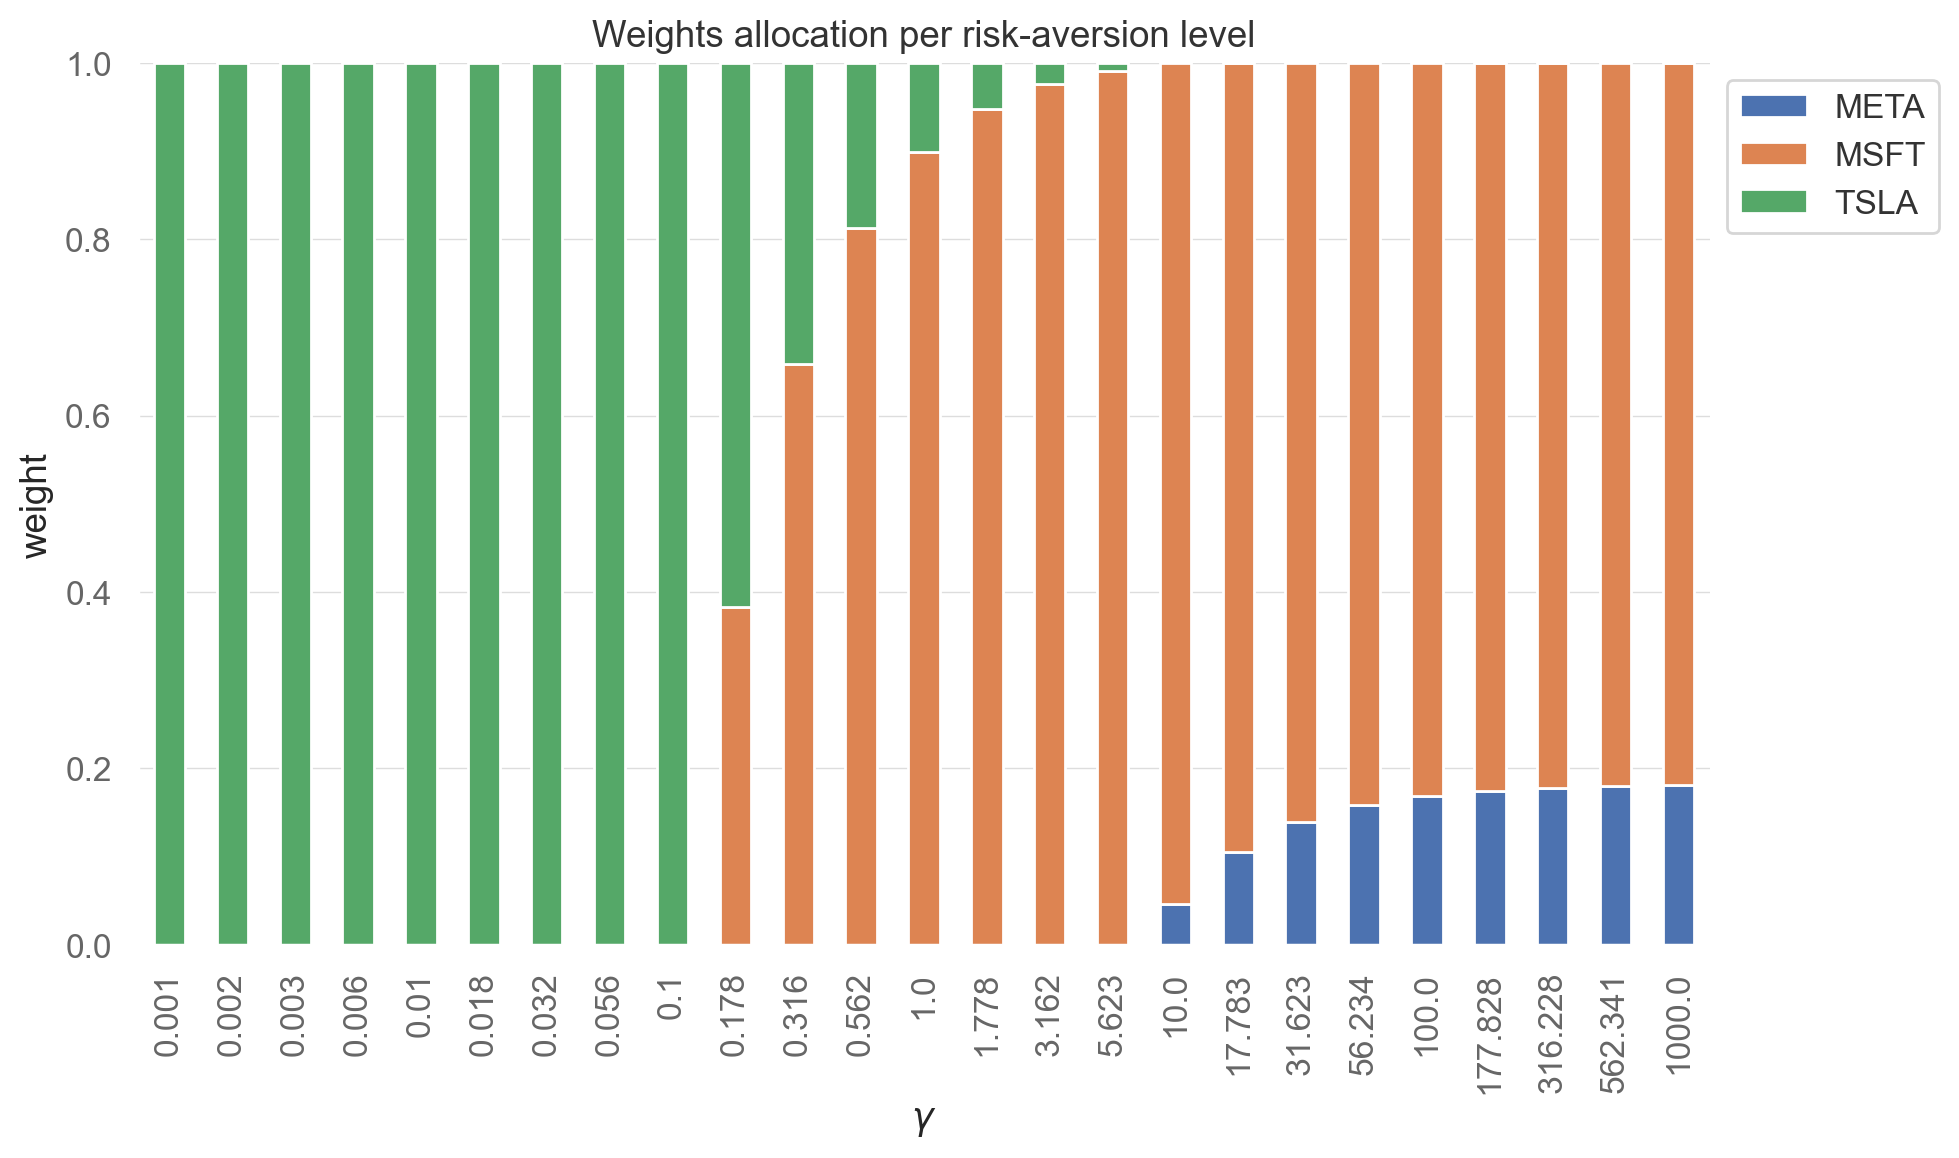

In [50]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind="bar", stacked=True) 
ax.set(title="Weights allocation per risk-aversion level",
       xlabel=r"$\gamma$", 
       ylabel="weight")
ax.legend(bbox_to_anchor=(1,1))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_13", dpi=200)

6. Plot the Efficient Frontier, together with the individual assets:

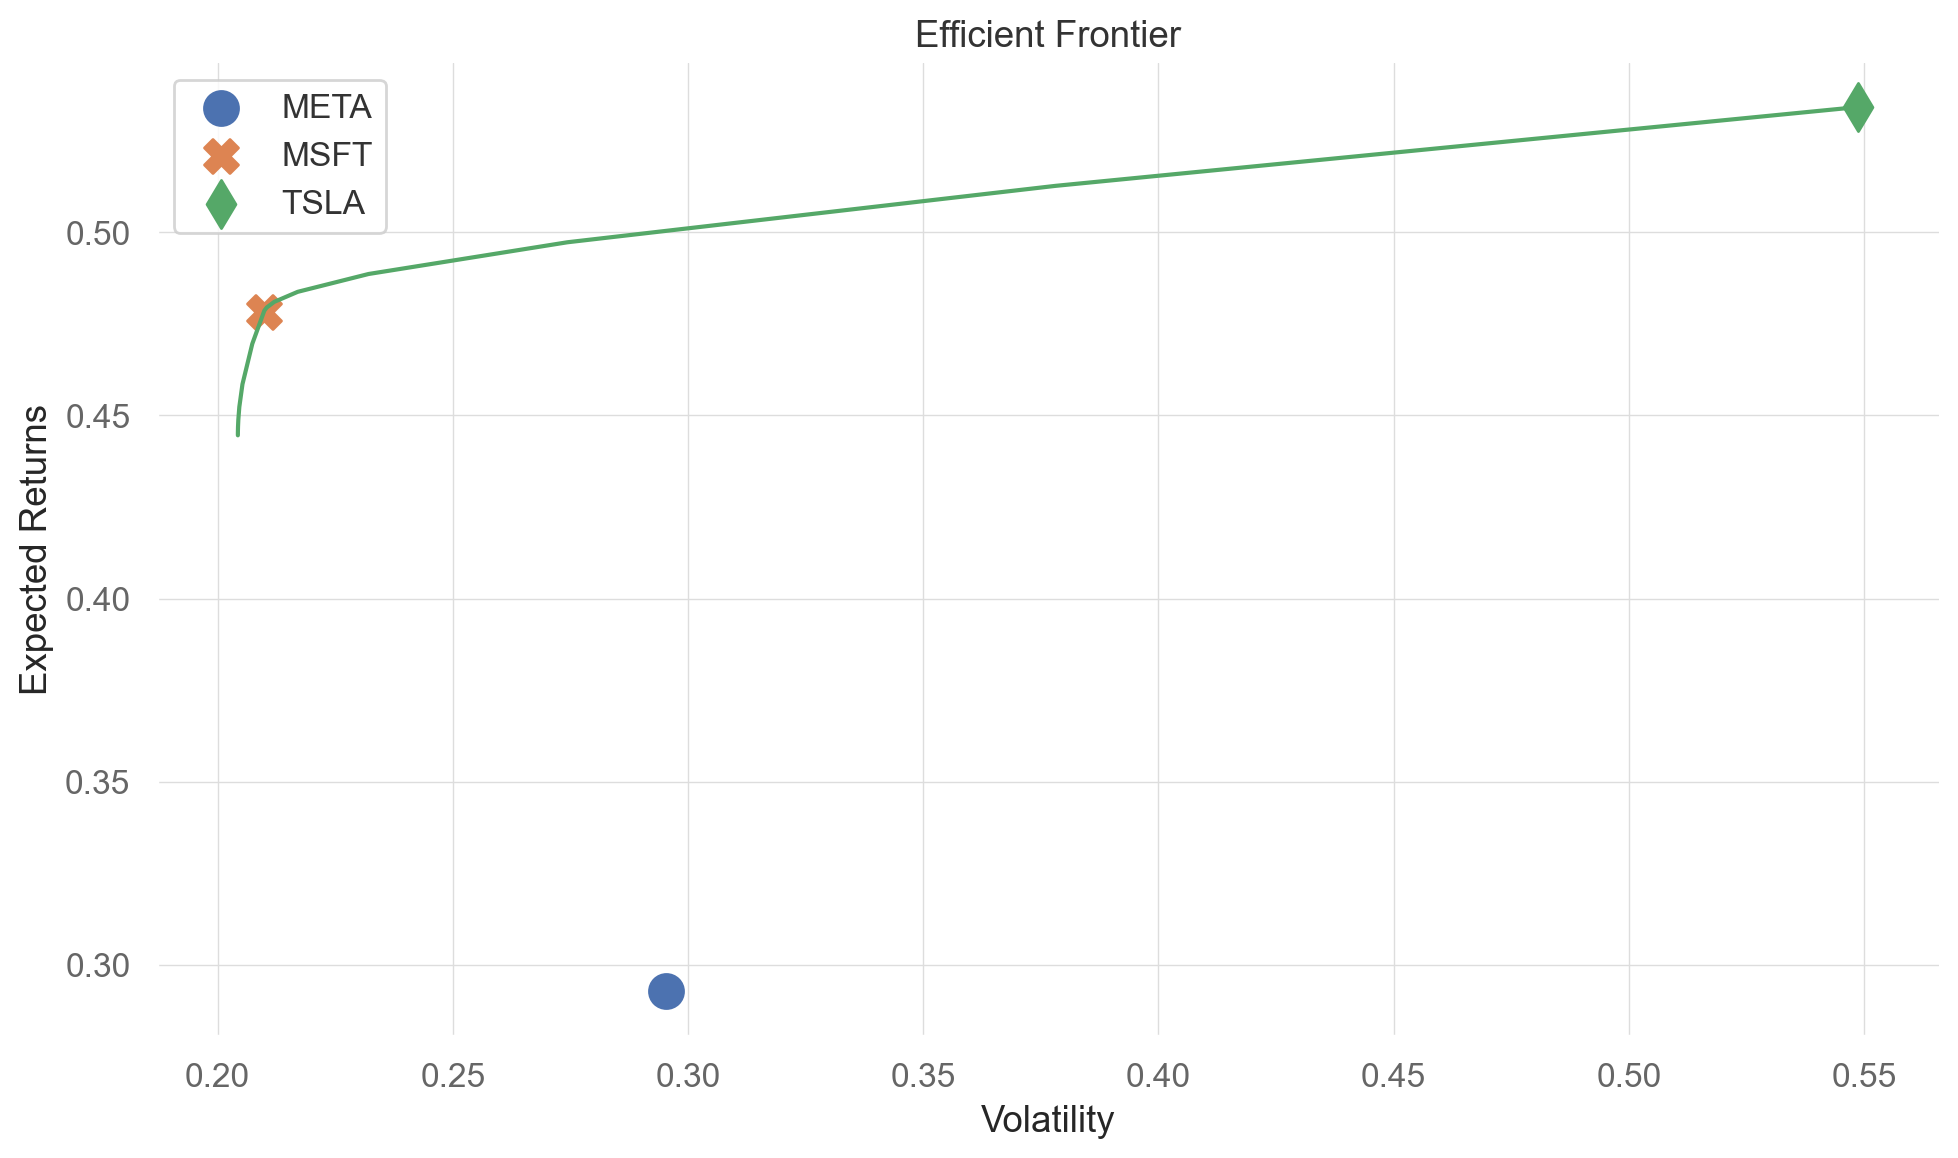

In [51]:
#MARKERS = ["o", "X", "d", "*"]

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-")
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKERS[asset_index], 
                 label=ASSETS[asset_index],
                 s=150)
ax.set(title="Efficient Frontier",
       xlabel="Volatility", 
       ylabel="Expected Returns")
ax.legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_14", dpi=200)

### There's more

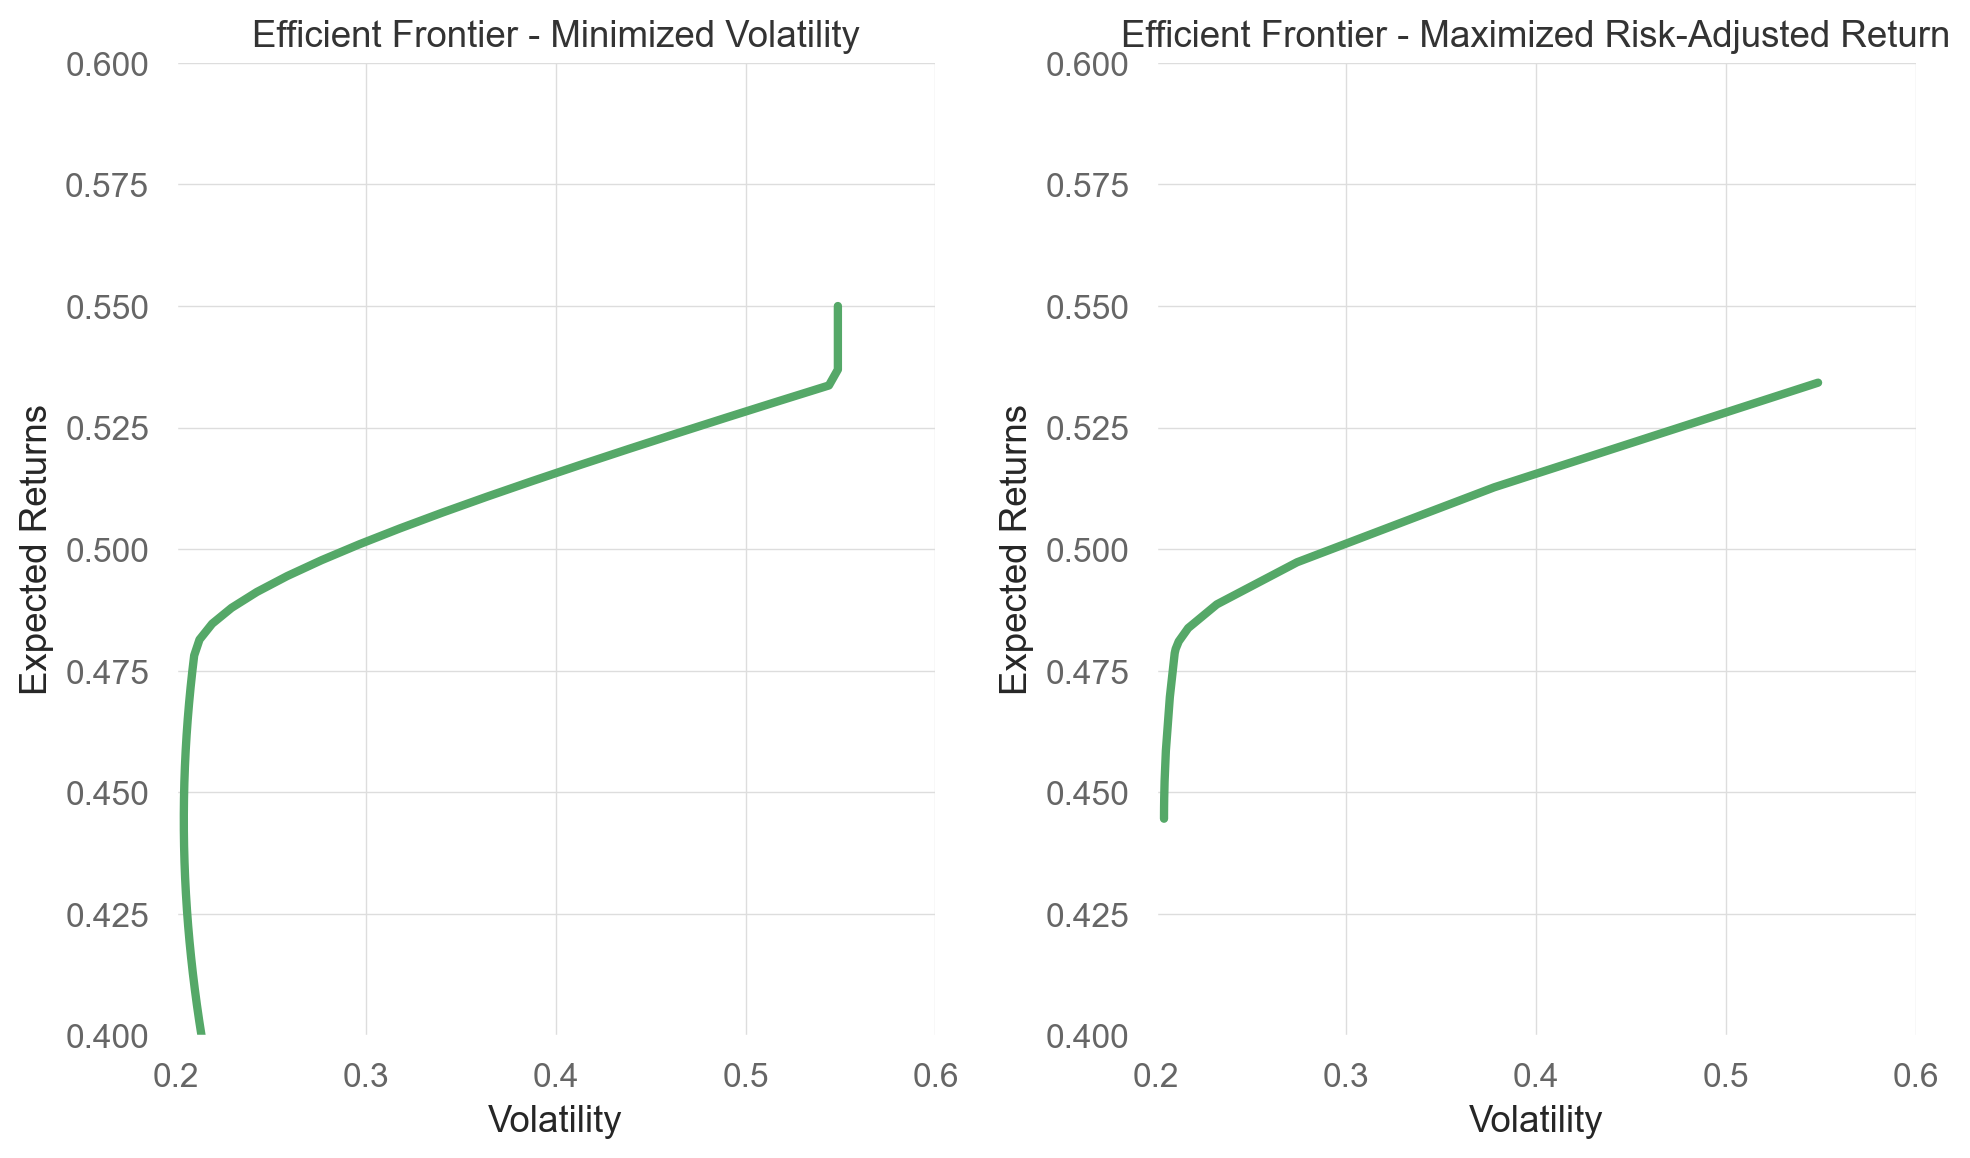

In [52]:
x_lim = [0.2, 0.6]
y_lim = [0.4, 0.6]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, "g-", linewidth=3)
ax[0].set(title="Efficient Frontier - Minimized Volatility",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-", linewidth=3)
ax[1].set(title="Efficient Frontier - Maximized Risk-Adjusted Return",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_15", dpi=200)

In [53]:
max_leverage = cp.Parameter()
prob_with_leverage = cp.Problem(objective_function, 
                                [cp.sum(weights) == 1, 
                                cp.norm(weights, 1) <= max_leverage])

In [54]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l = np.zeros((N_POINTS, len_leverage))
portf_rtn_l = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma_par.value = gamma_range[gamma_ind]
        prob_with_leverage.solve()
        portf_vol_l[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value
        

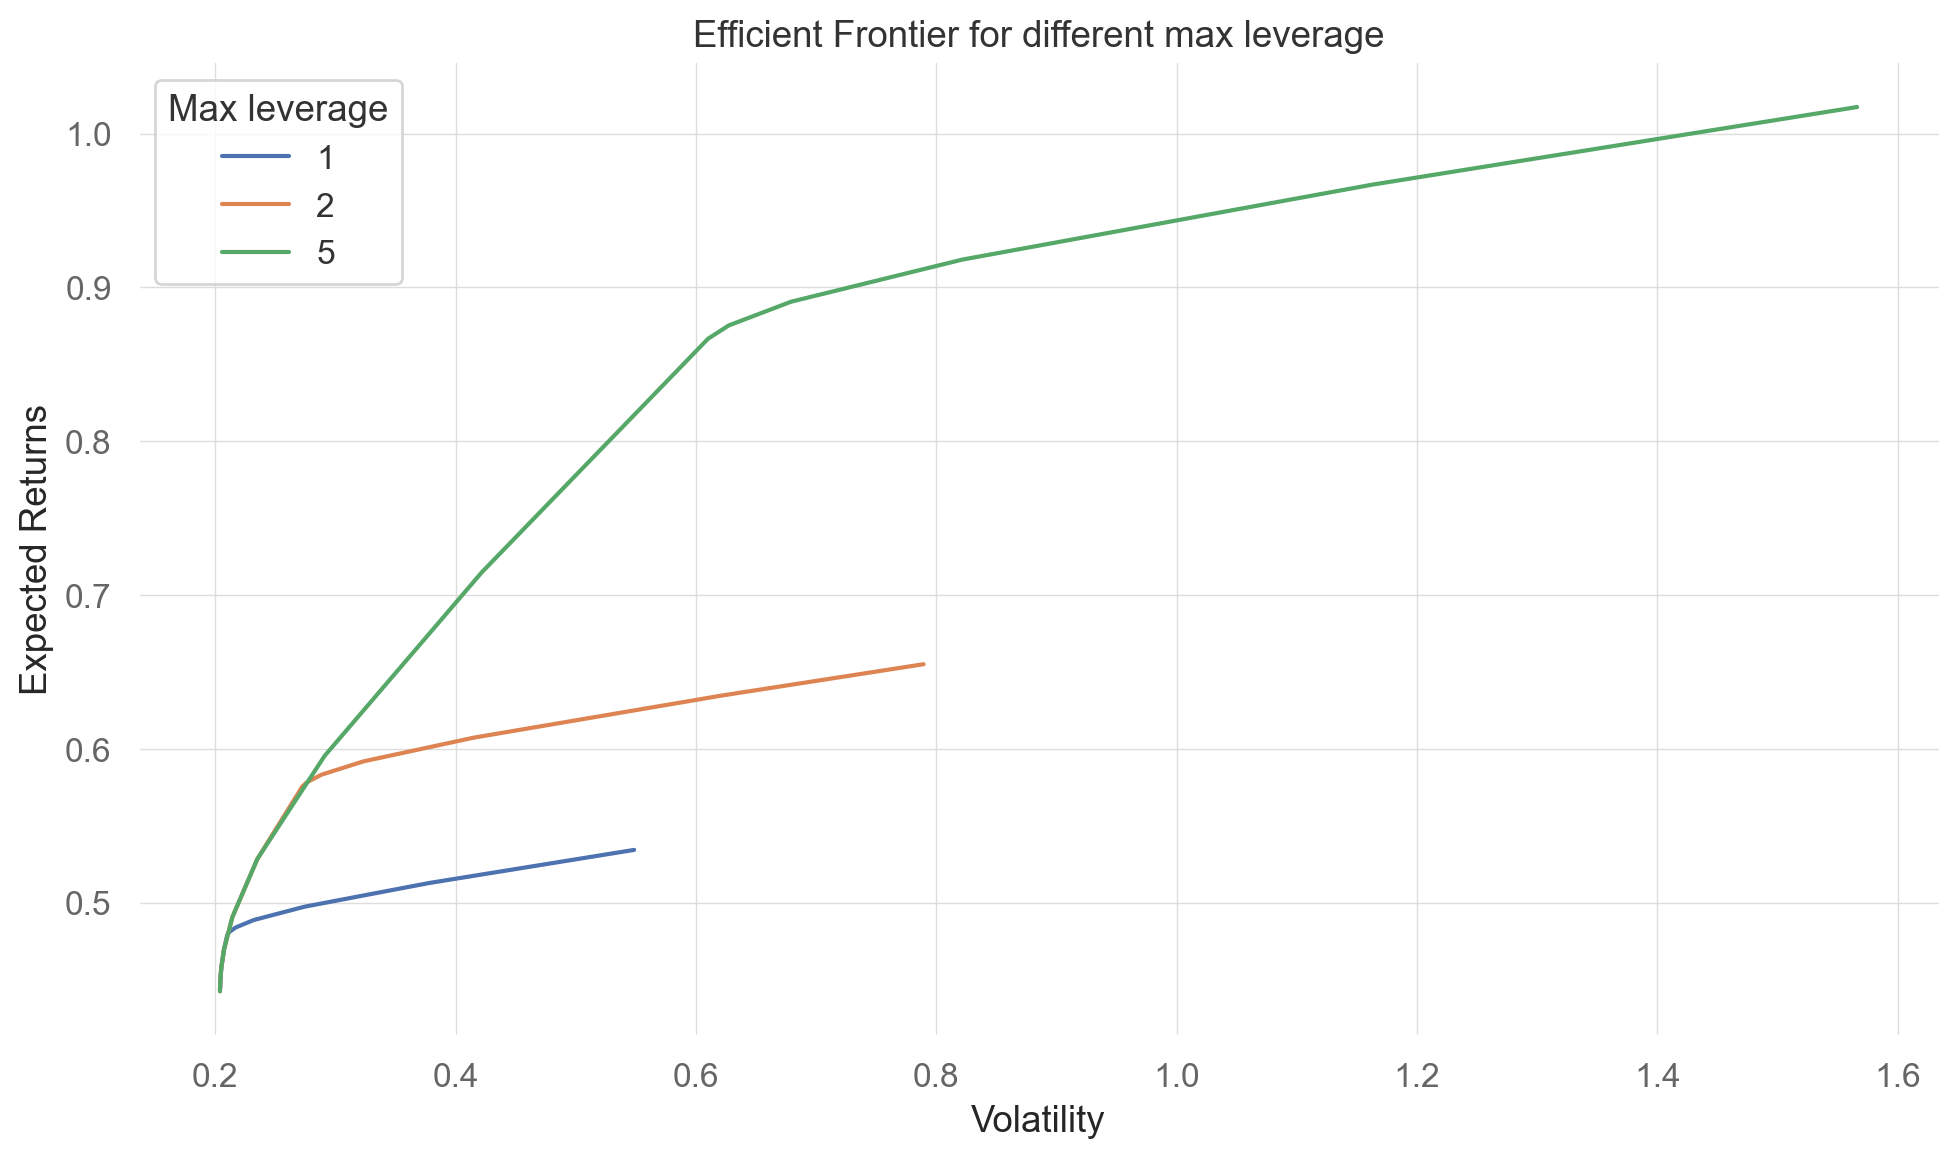

In [55]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l[:, leverage_index], 
             portf_rtn_l[:, leverage_index], 
             label=f"{leverage}")

ax.set(title="Efficient Frontier for different max leverage",
       xlabel="Volatility", 
       ylabel="Expected Returns")
ax.legend(title="Max leverage")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_16", dpi=200)

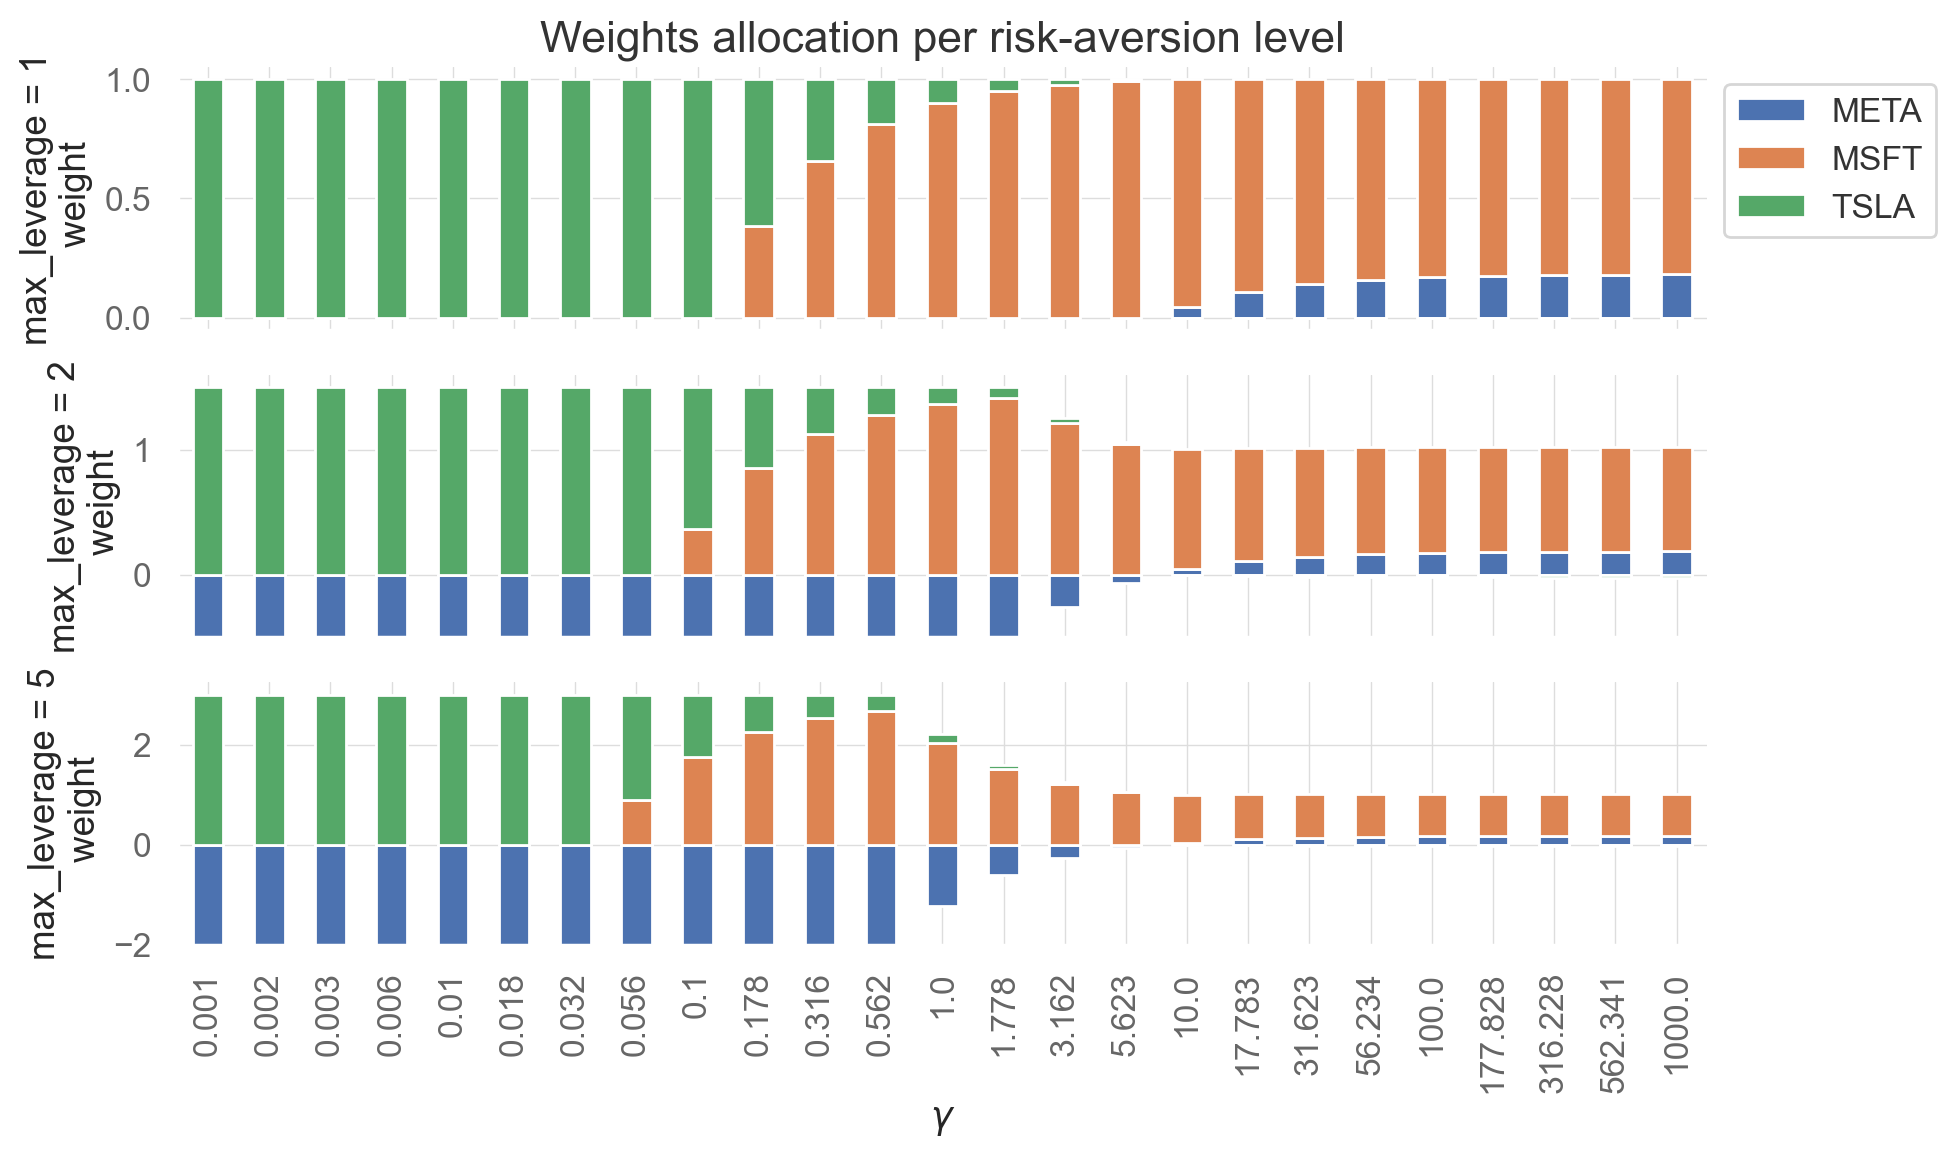

In [56]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind="bar", 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(
        ylabel=(f"max_leverage = {LEVERAGE_RANGE[ax_index]}" 
                "\n weight")
    )

    
ax[len_leverage - 1].set(xlabel=r"$\gamma$")
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title("Weights allocation per risk-aversion level",
                fontsize=16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_17", dpi=200)

## 11.5 Finding the optimal portfolio with Hierarchical Risk Parity

### How to do it...

1. Import the libraries:


In [57]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import returns_from_prices
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.discrete_allocation import (
    DiscreteAllocation, get_latest_prices
)
from pypfopt import plotting


2. Download the stock prices of the 10 biggest US tech companies:

In [58]:
ASSETS = ["AAPL", "MSFT", "AMZN", "GOOG", "META", 
          "V", "NVDA", "MA", "PYPL", "NFLX"]

prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31")
prices_df = prices_df["Adj Close"]
prices_df

[*********************100%%**********************]  10 of 10 completed


Ticker            AAPL        AMZN        GOOG          MA        META  \
Date                                                                     
2021-01-04  127.002106  159.331497   86.412003  345.084106  268.654968   
2021-01-05  128.572357  160.925507   87.045998  341.088318  270.682800   
2021-01-06  124.244377  156.919006   86.764503  341.215912  263.030914   
2021-01-07  128.483994  158.108002   89.362503  343.919220  268.455170   
2021-01-08  129.592972  159.134995   90.360497  347.841461  267.286407   
...                ...         ...         ...         ...         ...   
2021-12-23  174.066528  171.068497  147.142502  355.744965  334.884674   
2021-12-27  178.065659  169.669495  148.063995  355.478607  345.813080   
2021-12-28  177.038712  170.660995  146.447998  355.942322  345.853058   
2021-12-29  177.127579  169.201004  146.504501  356.445465  342.576538   
2021-12-30  175.962387  168.644501  146.002502  356.149475  343.994995   

Ticker            MSFT        NFLX        NVDA        PYPL           V  
Date                                                                    
2021-01-04  211.605286  522.859985  130.833969  231.919998  212.716629  
2021-01-05  211.809402  520.799988  133.739807  234.910004  209.541916  
2021-01-06  206.317352  500.489990  125.855431  226.830002  207.695679  
2021-01-07  212.188538  508.890015  133.133667  235.039993  208.858109  
2021-01-08  213.481369  510.399994  132.462692  242.460007  210.460129  
...                ...         ...         ...         ...         ...  
2021-12-23  328.062073  614.090027  295.977844  192.009995  212.902863  
2021-12-27  335.668457  613.119995  309.009308  192.009995  213.895538  
2021-12-28  334.492157  610.710022  302.788177  190.100006  214.308350  
2021-12-29  335.178284  610.539978  299.582733  189.970001  214.426270  
2021-12-30  332.600403  612.090027  295.438629  191.880005  214.131393  

[251 rows x 10 columns]

3. Calculate the returns from prices:

In [59]:
rtn_df = returns_from_prices(prices_df)

4. Find the optimal allocation using Hierarchical Risk Parity:

In [60]:
hrp = HRPOpt(returns=rtn_df)
hrp.optimize()

OrderedDict([('AAPL', 0.1306461015250584),
             ('AMZN', 0.15614842206996235),
             ('GOOG', 0.0853238992108037),
             ('MA', 0.09984440454267539),
             ('META', 0.08111180580403442),
             ('MSFT', 0.10915983285703222),
             ('NFLX', 0.10213814934844477),
             ('NVDA', 0.04432890760631263),
             ('PYPL', 0.052980826312054266),
             ('V', 0.1383176507236218)])

5. Display the (cleaned) weights:

In [61]:
weights = hrp.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.13065), ('AMZN', 0.15615), ('GOOG', 0.08532), ('MA', 0.09984), ('META', 0.08111), ('MSFT', 0.10916), ('NFLX', 0.10214), ('NVDA', 0.04433), ('PYPL', 0.05298), ('V', 0.13832)])


We can create a simple pie chart to visualize the optimized portfolio weights:

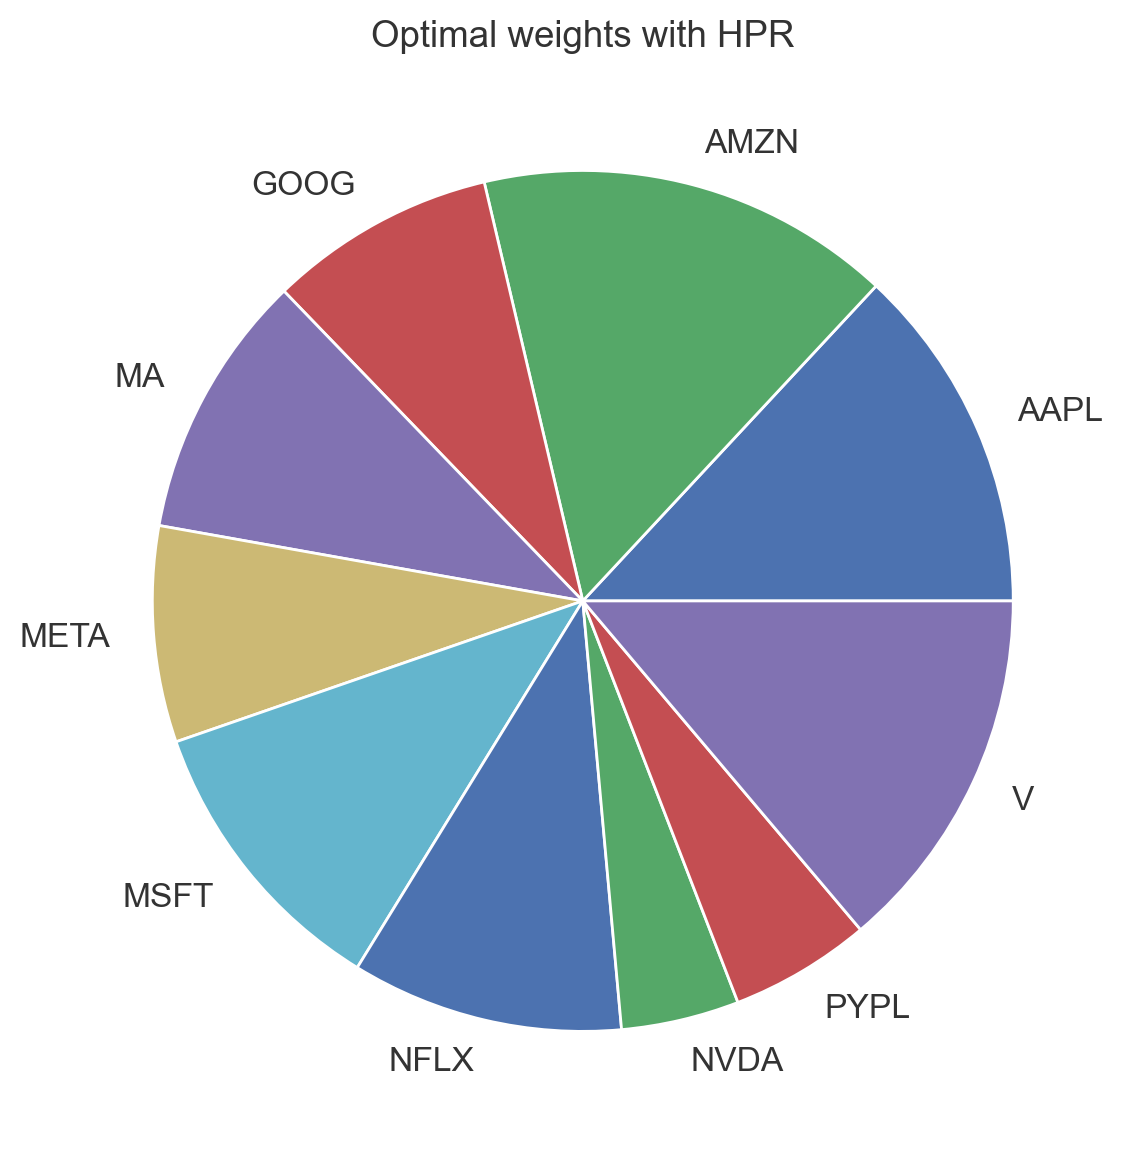

In [62]:
pd.Series(weights).plot(kind="pie",
                        title="Optimal weights with HPR");

sns.despine()
plt.tight_layout()

6. Calculate the portfolio performance:

In [63]:
hrp.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 25.2%
Annual volatility: 19.2%
Sharpe Ratio: 1.31


7. Visualize the hierarchical clustering used for finding the portfolio weights:

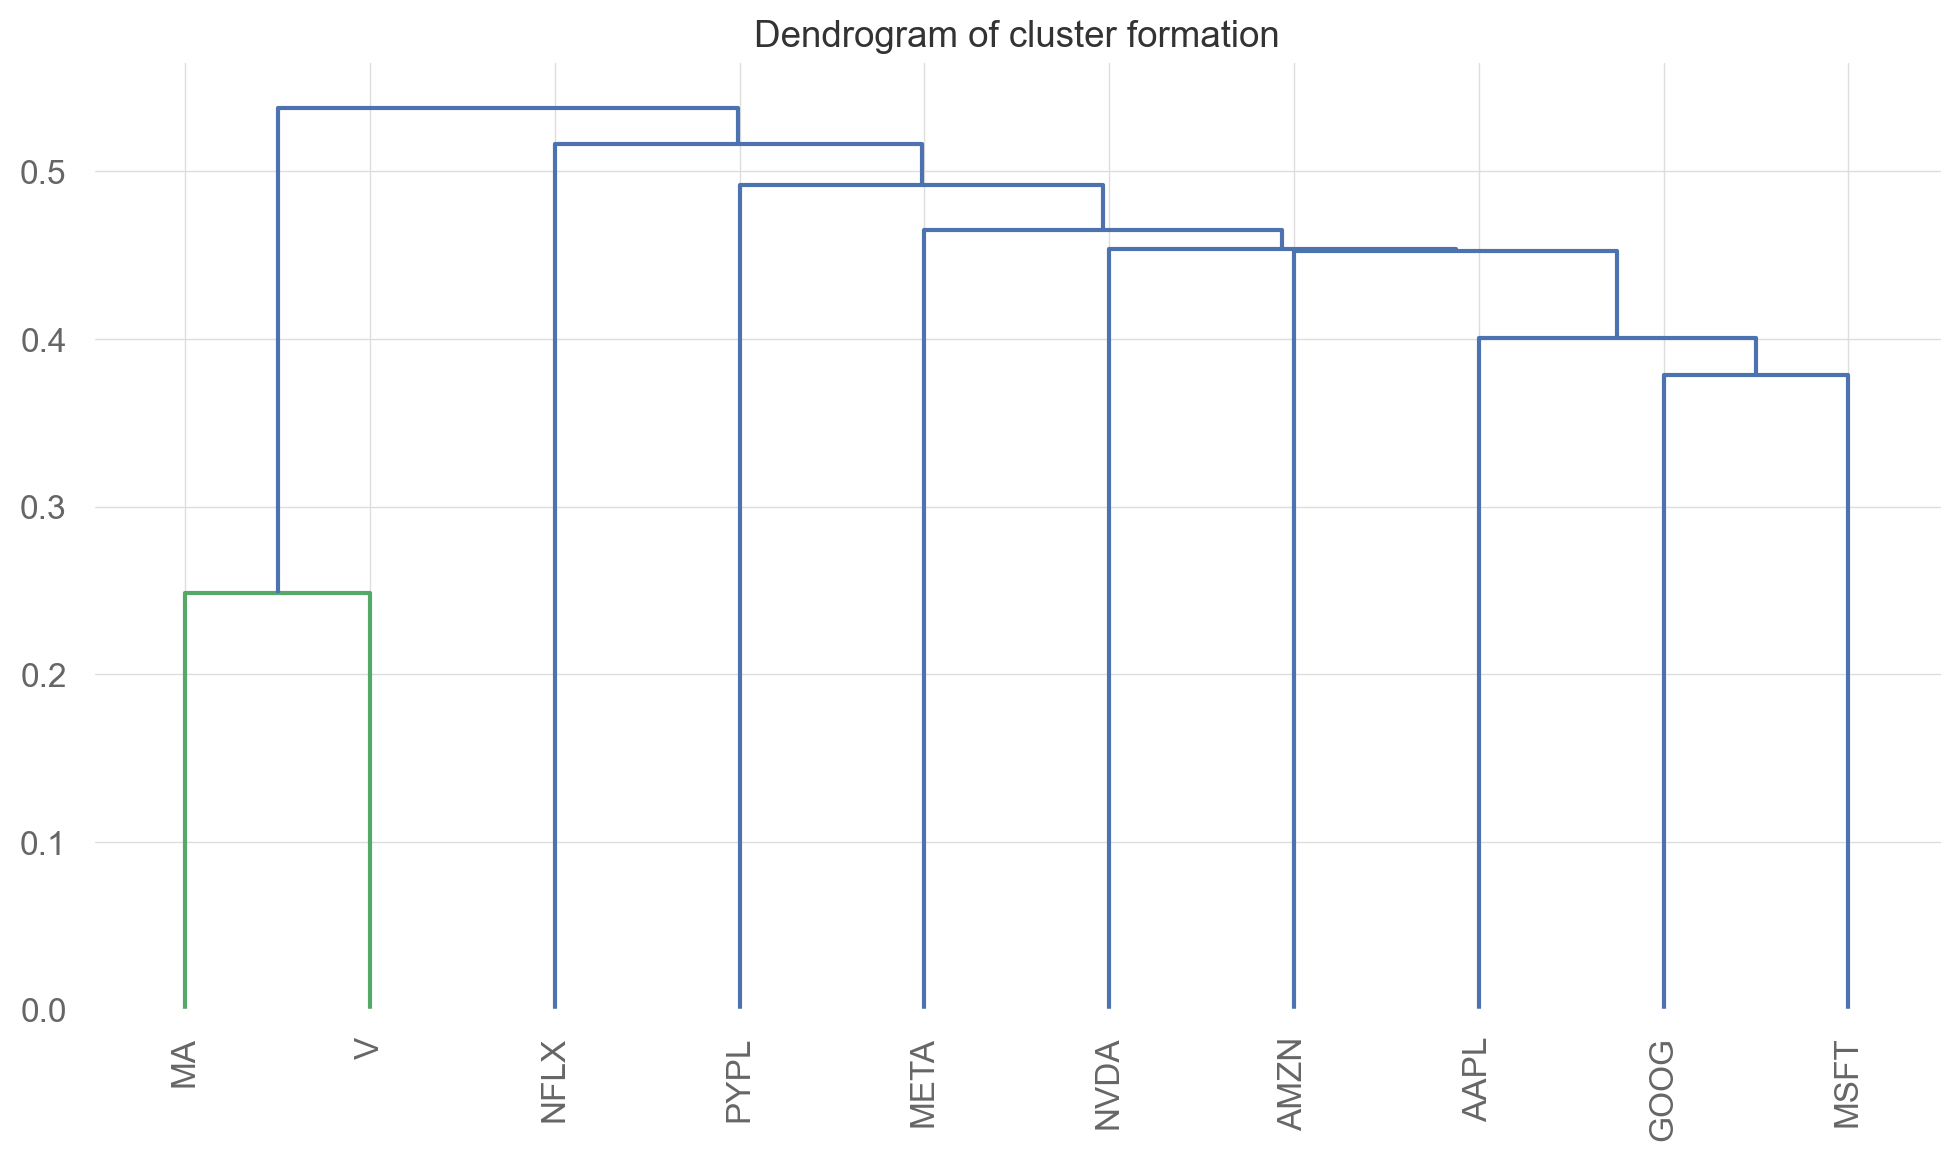

In [64]:
fig, ax = plt.subplots()
plotting.plot_dendrogram(hrp, ax=ax) 
ax.set_title("Dendrogram of cluster formation")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_18", dpi=200)

8. Find the number of stocks to buy using 50,000 USD:

In [65]:
latest_prices = get_latest_prices(prices_df)
allocation_finder = DiscreteAllocation(weights, 
                                       latest_prices, 
                                       total_portfolio_value=50000)
allocation, leftover = allocation_finder.lp_portfolio()
print(allocation)
print(leftover)

{'AAPL': 37, 'AMZN': 46, 'GOOG': 29, 'MA': 14, 'META': 12, 'MSFT': 16, 'NFLX': 8, 'NVDA': 8, 'PYPL': 14, 'V': 33}
49.14770892151137


In [66]:
# an alternative allocation using the greedy iterative algorithm
allocation, leftover = allocation_finder.greedy_portfolio()
print(allocation)
print(leftover)

{'AMZN': 46, 'V': 32, 'AAPL': 37, 'MSFT': 16, 'NFLX': 9, 'MA': 14, 'GOOG': 29, 'META': 12, 'PYPL': 13, 'NVDA': 7}
138.5077362060547


### There's more

1. Import the libraries:

In [67]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier

2. Get the expected returns and the covariance matrix:

In [68]:
mu = mean_historical_return(prices_df)
S = CovarianceShrinkage(prices_df).ledoit_wolf()

3. Find and plot the Efficient Frontier:

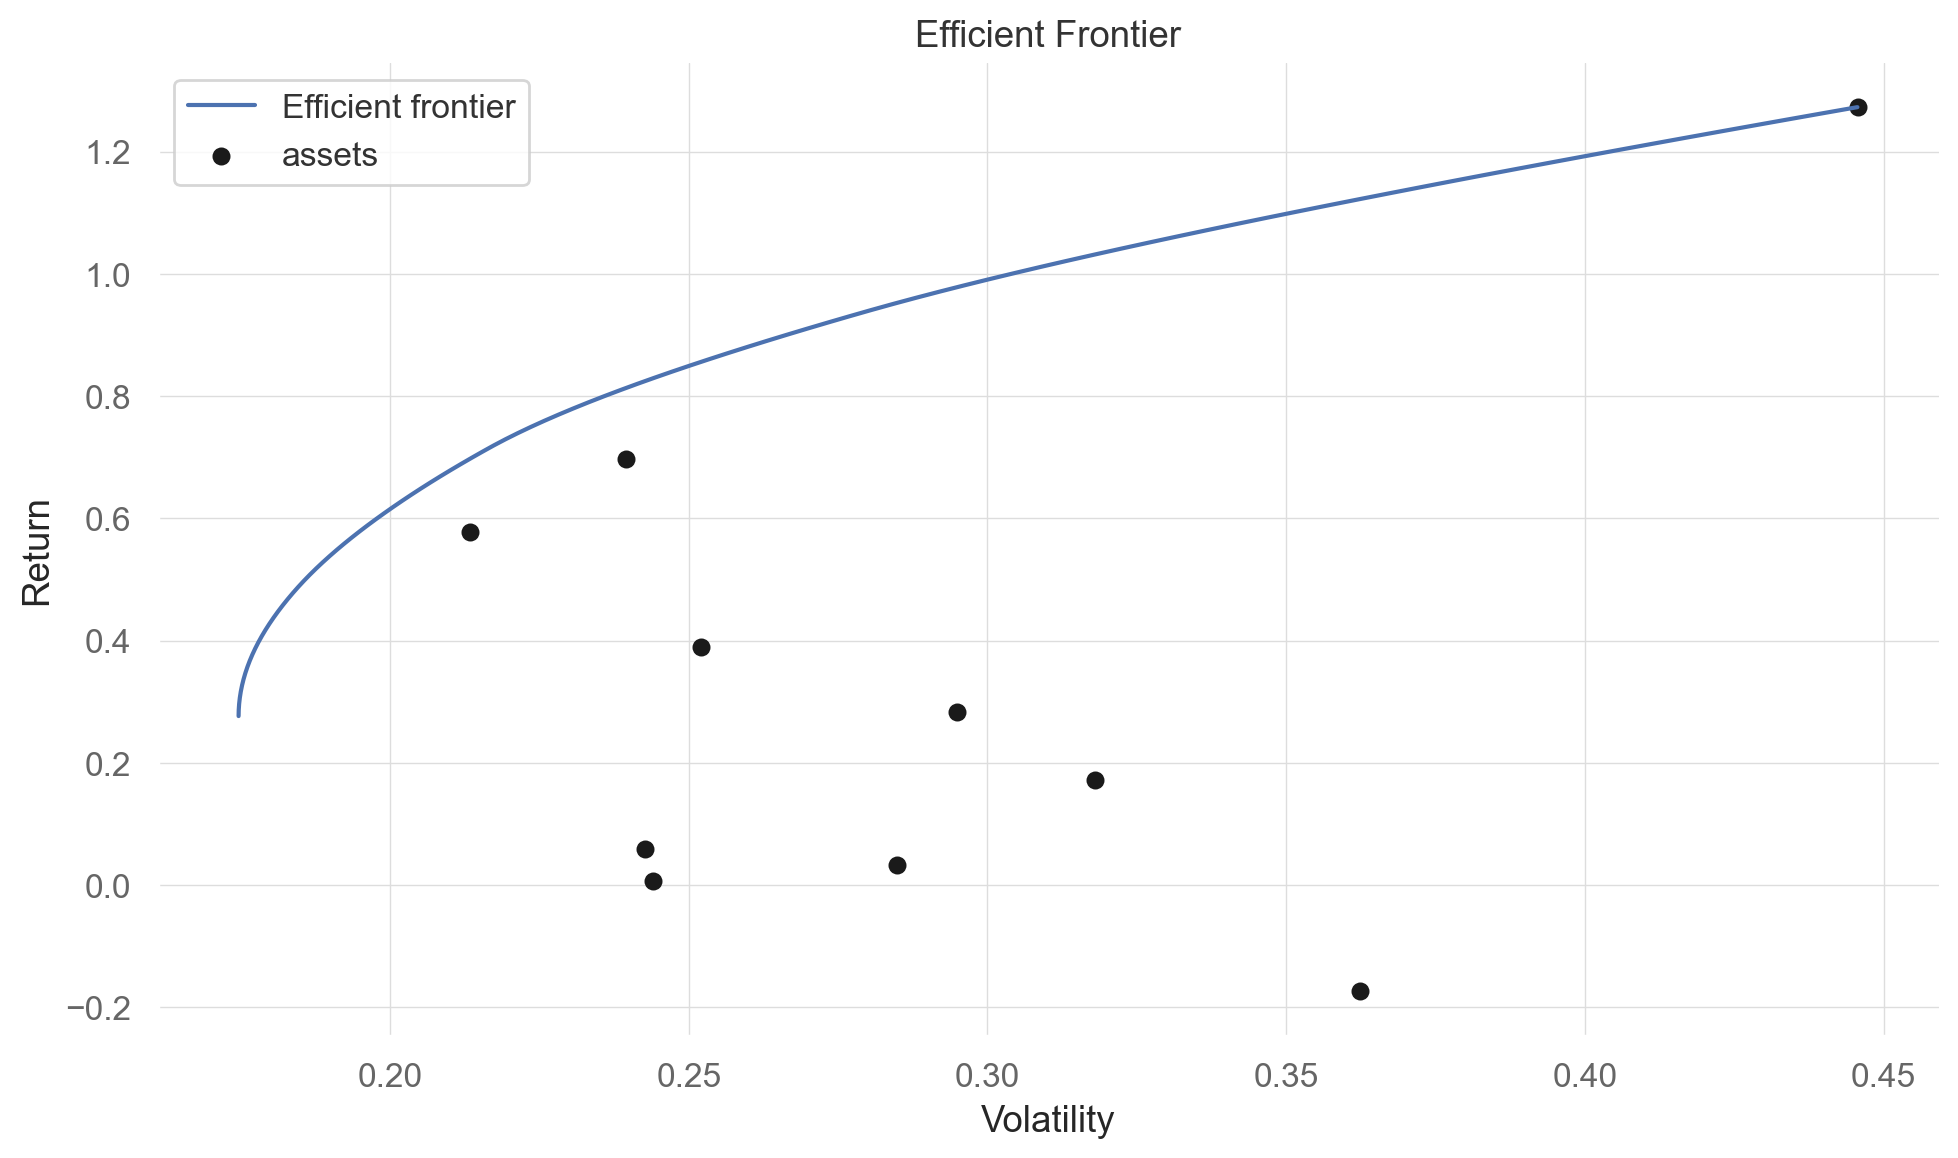

In [69]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier")


sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_19", dpi=200)

4. Identify the tangency portfolio:

In [70]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())


OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('GOOG', 0.51897), ('MA', 0.0), ('META', 0.0), ('MSFT', 0.19993), ('NFLX', 0.0), ('NVDA', 0.28109), ('PYPL', 0.0), ('V', 0.0)])


In [71]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 83.5%
Annual volatility: 24.6%
Sharpe Ratio: 3.40


We get a warning when we are trying to use a different risk-free rate as the one used for finding the tangency portfolio.

In [72]:
ef.portfolio_performance(verbose=True);

Expected annual return: 83.5%
Annual volatility: 24.6%
Sharpe Ratio: 3.40


/Users/encore/miniconda3/envs/zj38/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


5. Add L2 regularization to the portfolio optimization problem:

In [73]:
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)

weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.07334), ('AMZN', 0.0), ('GOOG', 0.29714), ('MA', 0.0), ('META', 0.0), ('MSFT', 0.21838), ('NFLX', 0.0), ('NVDA', 0.41114), ('PYPL', 0.0), ('V', 0.0)])


/Users/encore/miniconda3/envs/zj38/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


6. Find the tangency portfolio with short-selling allowed:

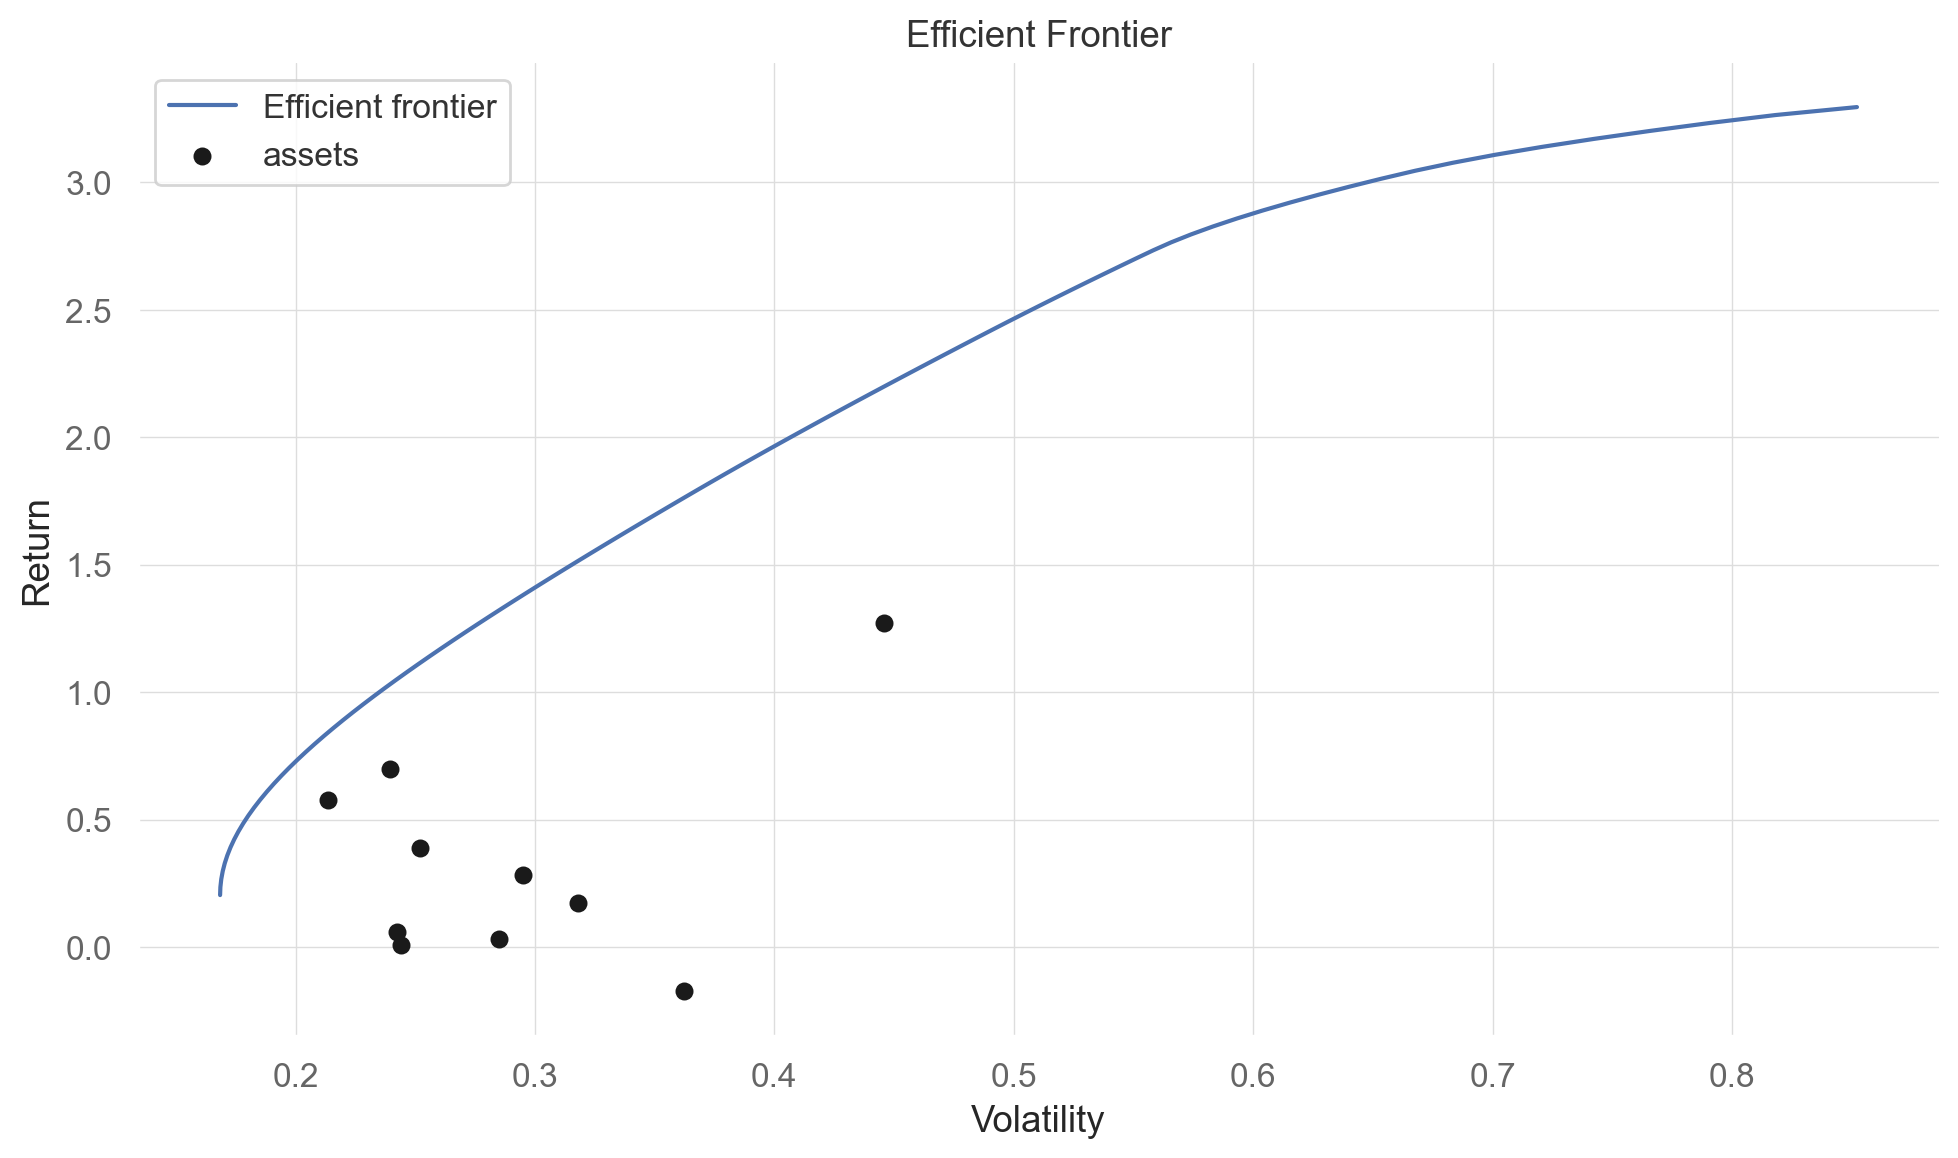

In [74]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier")


sns.despine()
plt.tight_layout()

In [75]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.22296), ('AMZN', -0.94318), ('GOOG', 1.0), ('MA', -0.0368), ('META', -0.01186), ('MSFT', 0.92301), ('NFLX', -0.13341), ('NVDA', 0.73156), ('PYPL', -0.78314), ('V', 0.03085)])


In [76]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 230.1%
Annual volatility: 46.6%
Sharpe Ratio: 4.93
